# Act 3: Generate from Data

In this notebook, you'll generate new video content from existing data - creating trailer images and videos automatically from your scene library. In a typical workflow, this means opening editing software for a single clip, extracting frames, calling AI APIs, crafting prompts, exporting the media output, experimenting with prompt tweaks, then writing some for loops in Python scripts to rinse and repeat 100 times for 100 clips.

The techniques you'll learn apply to any workflow that chains transformations and applies them across data:

- Chaining AI models where outputs from one become inputs to the next
- Applying multi-step pipelines to entire datasets without loops
- Testing transformations on single items before processing all data
- Building workflows that incrementally process new data as it arrives

## In this notebook
1. **Extract Frames** - Pull representative frames from each video scene
2. **Generate Creative Prompts** - Use multimodal AI to create trailer descriptions from frames and transcripts
3. **Create Visual Content** - Generate images and videos from AI prompts
4. **Apply Across All Scenes** - Run the workflow on your entire scene library automatically

**Prerequisites:** You'll need a Gemini API key from [aistudio.google.com](https://aistudio.google.com/apikey). See [Pixeltable's API key configuration guide](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys) for setup instructions.

**Models used in this notebook:**
- `gemini-2.0-flash-exp` (Text-out models) - Used for generating text descriptions from images
- `imagen-4.0-generate` (Multi-modal generative models) - Used for generating images from text
- `veo-3.0-generate` (Multi-modal generative models) - Used for generating videos from images

In [16]:
import pixeltable as pxt
import pixeltable.functions as pxtf

As we've been doing, we'll take a look at the tables we can "get":

In [17]:
pxt.list_tables()

['primetime_vids', 'sentences', 'scene_view']

We'll be working with our `scene_view` table. 

In [18]:
scene_view = pxt.get_table('scene_view')

You can uncomment the code below if you have already gone through this notebook and want to start fresh with the state of `scene_view` before adding any generative AI model inputs or outputs.

In [ ]:
#scene_view.drop_column(scene_view.trailer_image)
#scene_view.drop_column(scene_view.trailer_prompt)
#scene_view.drop_column(scene_view.beginning_frame)

We can also check out the history of our table, to revisit where we've been!

In [21]:
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,36,2026-01-25 17:27:58.755373+00:00,None,schema,0,10,0,0,Deleted: beginning_frame
1,35,2026-01-25 17:27:58.723039+00:00,None,schema,0,10,0,0,Deleted: trailer_prompt
2,34,2026-01-24 01:58:40.185547+00:00,None,schema,0,10,0,0,Added: trailer_prompt
3,33,2026-01-24 01:56:25.606606+00:00,None,schema,0,10,0,0,Added: beginning_frame
4,32,2026-01-24 01:56:09.895455+00:00,None,schema,0,10,0,0,Deleted: beginning_frame
5,31,2026-01-24 01:56:09.864400+00:00,None,schema,0,10,0,0,Deleted: trailer_prompt
6,30,2026-01-24 01:56:09.833327+00:00,None,schema,0,10,0,0,Deleted: trailer_image
7,29,2026-01-24 01:17:56.527267+00:00,None,schema,0,10,0,0,Added: trailer_image
8,28,2026-01-24 00:11:50.661208+00:00,None,schema,0,10,0,0,Added: trailer_prompt
9,27,2026-01-24 00:11:28.827811+00:00,None,schema,0,10,0,0,Added: beginning_frame


In addition to seeing table history, you can do time travel, rollback to a previous version, and revert changes. See this page in our docs for more: https://docs.pixeltable.com/platform/version-control

As a reminder, here is our table schema:

In [22]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang             Json                             transcription.language
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

## 01 - Extract Frames

You already have `scene_view` from Act 2 with video segments for each scene. Now you'll add a computed column to extract a frame from each segment.

Computed columns work on views the same way they work on tables - they're automatically applied to every row. Here, `extract_frame()` is a Pixeltable UDF that pulls a single frame at a specific timestamp from each video segment. If anything changed in our base table, `primetime_vids`, any changes in scenes and frames would automatically be reflected in this view. That means adding or removing rows from that base table will trigger a parallel action in the view table.

This frame extraction happens once and is stored persistently. All 10 scenes are processed automatically. If you add a new row to the base table, only those new scenes and frames would be processed because Pixeltable does incremental updates.

In [23]:
scene_view.add_computed_column(
    beginning_frame=scene_view.video_segment.extract_frame(timestamp=0.5),
    if_exists='replace'
)

Added 10 column values with 0 errors in 0.34 s (29.41 rows/s)


10 rows updated.

here is a sneak peek at the frames:

pos,beginning_frame
1,
4,
2,

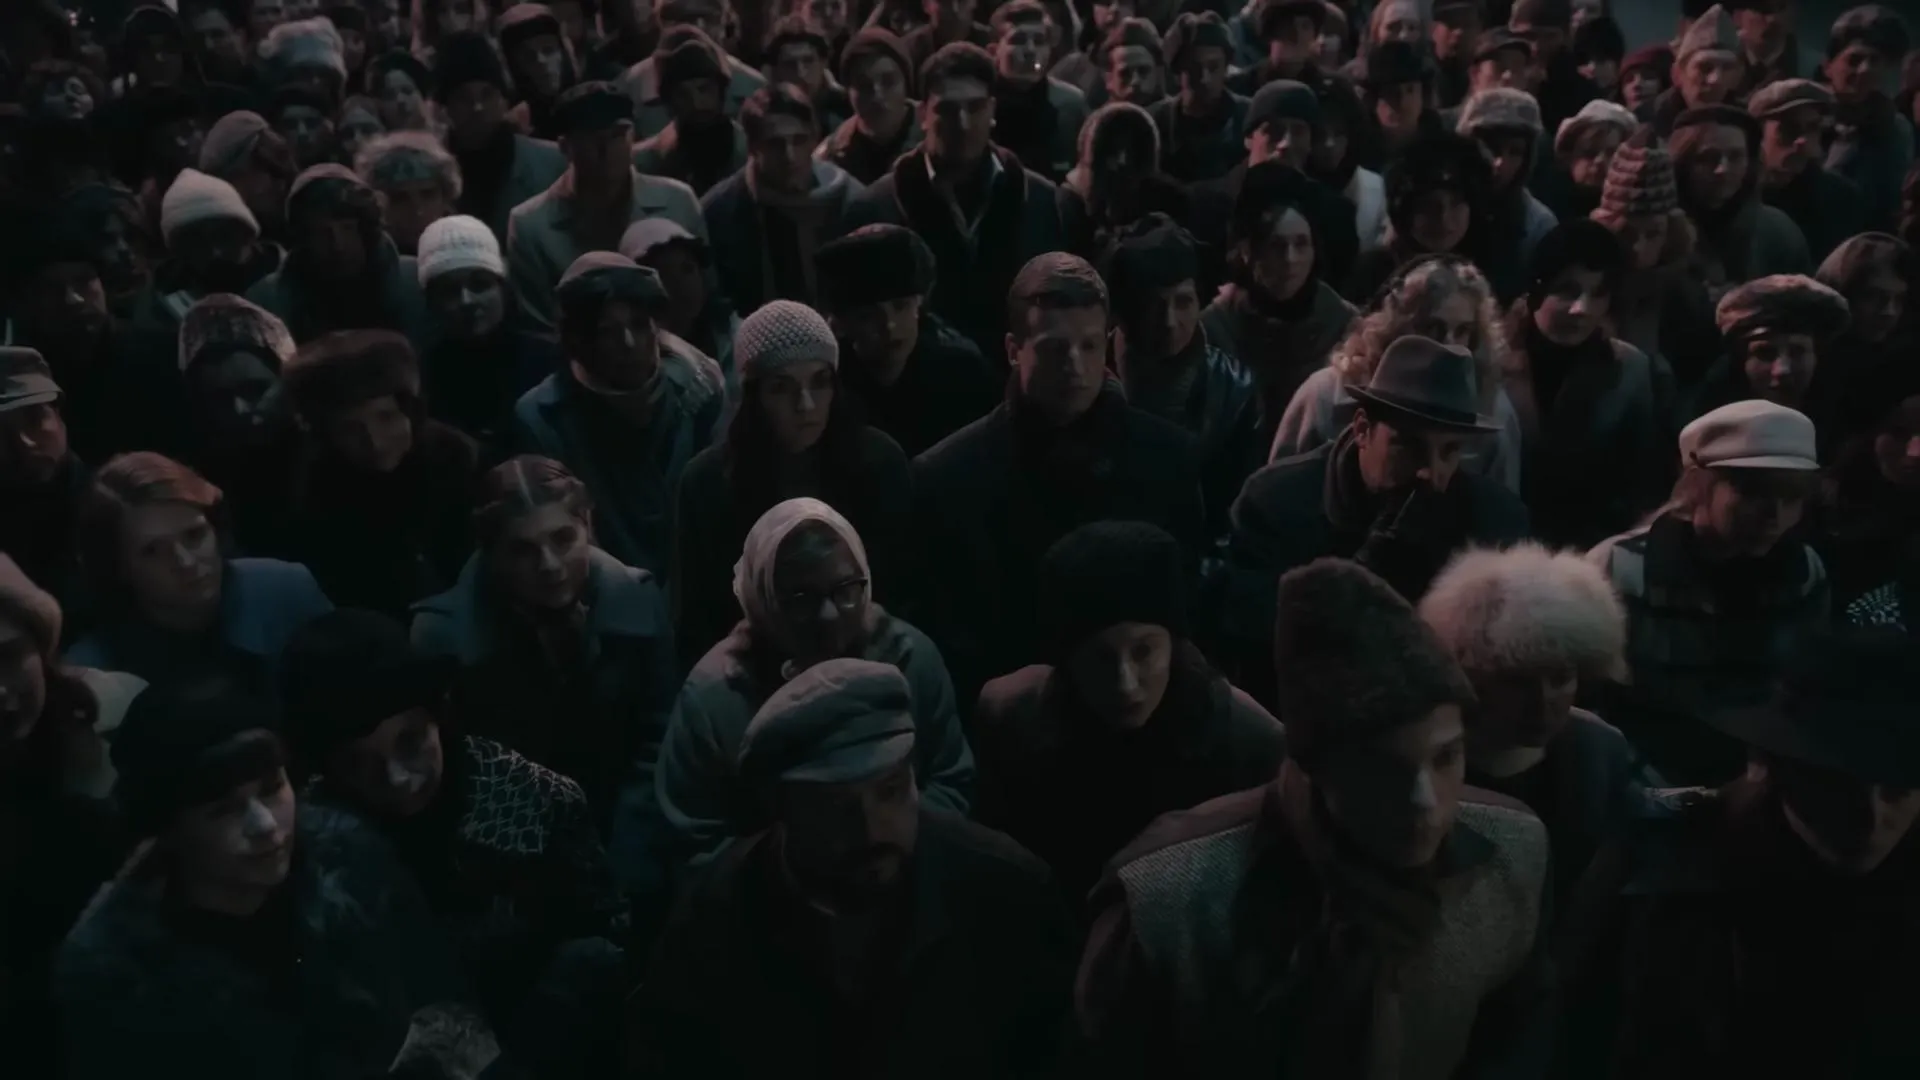
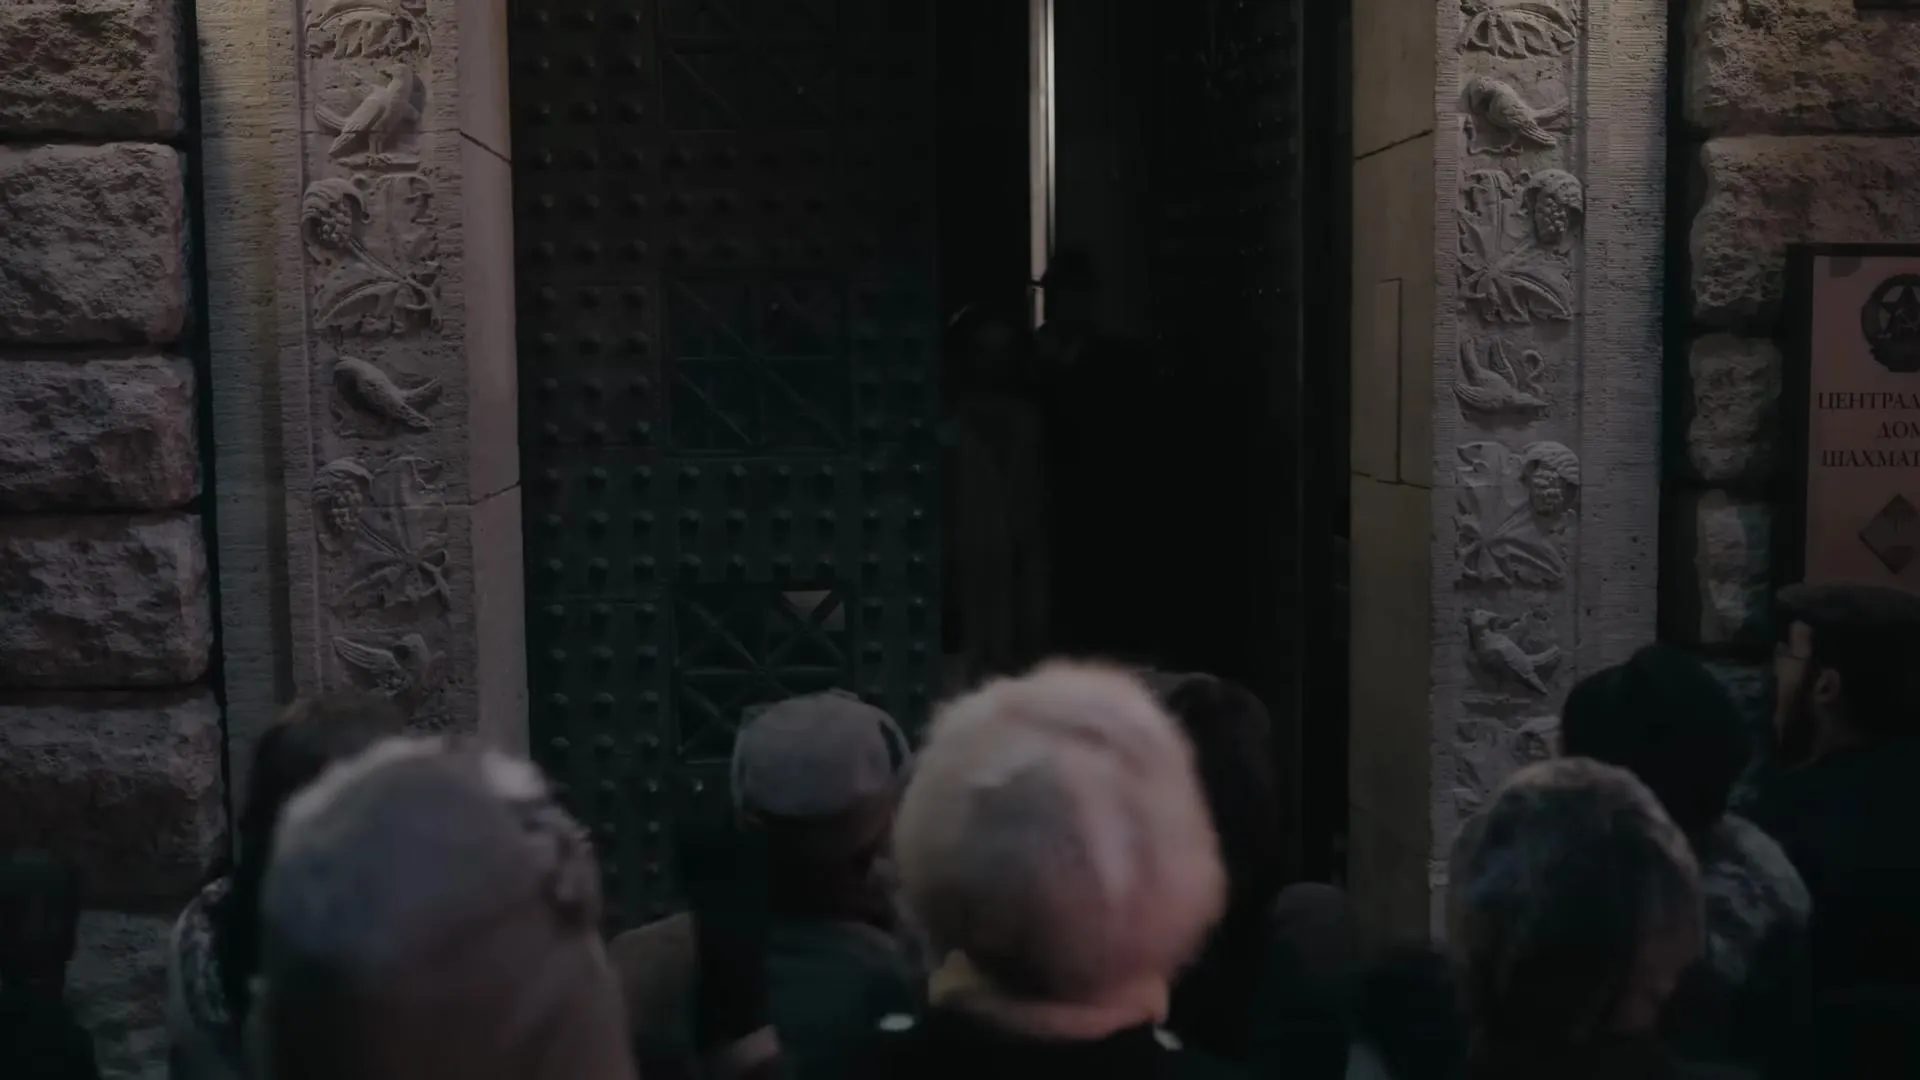
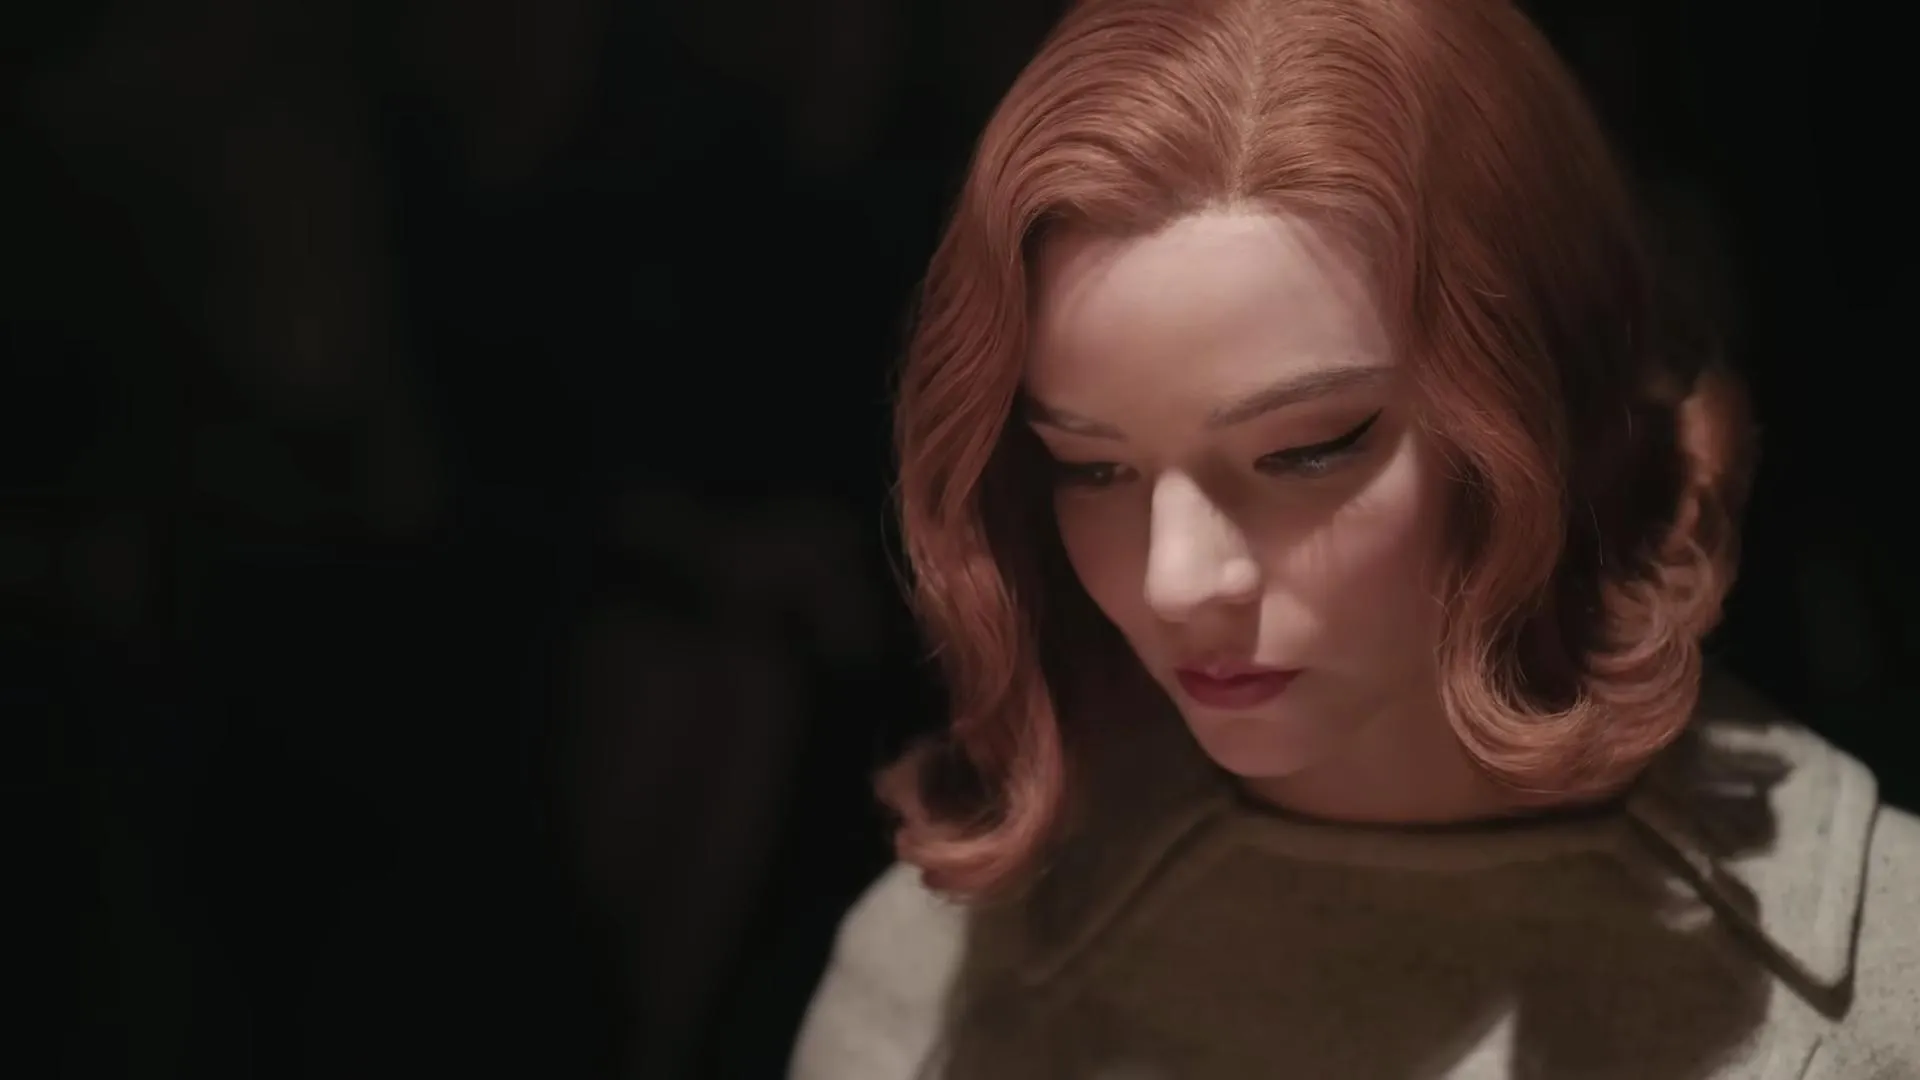

In [24]:
scene_view.select(scene_view.pos, scene_view.beginning_frame).limit(3).collect()

## 02 - Generate AI Prompts

Now let's use AI to generate creative trailer prompts for each scene.

We'll define a **Pixeltable expression** - a reusable transformation that references table columns. Expressions are powerful because:
- They can be used and reused in queries (`.select()`) or as computed columns (`.add_computed_column()`)
- When added as computed columns, they're automatically applied to new rows in a table
- They can reference multiple columns of any data type in a single operation

Here we'll create a **multimodal expression** that combines multiple data types in one API call:
- **Image data**: `scene_view.beginning_frame` (the extracted frame)
- **Text data**: `scene_view.transcript_text` (what's being said)
- **Context data**: `scene_view.title` and `scene_view.promo_text` (movie information)

All of these inputs are bundled together and sent to Gemini's `gemini-2.0-flash-exp` model in a single operation - combining vision and language understanding.

We'll use a careful workflow in this section: define the expression once, test it on one row with `.select().where()`, then apply it to all rows with `.add_computed_column()`. This workflow helps you iterate quickly before committing to expensive operations across your entire dataset.

Here is the composed prompt, written as a Pixeltable expression that uses the built-in Gemini UDF for `generate_content()`. 

In [25]:
trailer_prompt_expr = pxtf.gemini.generate_content(
    contents=[
        f'You are creating trailer prompts for an image generator. Movie: "{scene_view.title}". Description: {scene_view.promo_text}. This frame is from one scene. What is said: {scene_view.transcript_text}. Write ONLY a 1-2 sentence cinematic prompt for an image generator. Be visual and atmospheric. No text, no typography, no words in the image. Do not include any preamble or explanation.',
        scene_view.beginning_frame
    ],
    model='gemini-2.0-flash-exp'
)['candidates'][0]['content']['parts'][0]['text']

This hasn't been executed and no API calls are made yet - this is just the setup:

In [26]:
trailer_prompt_expr

generate_content(contents=['You are creating trailer prompts for an image generator. Movie: "title". Description: promo_text. This frame is from one scene. What is said: transcript_text. Write ONLY a 1-2 sentence cinematic prompt for an image generator. Be visual and atmospheric. No text, no typography, no words in the image. Do not include any preamble or explanation.', beginning_frame], model='gemini-2.0-flash-exp').candidates[0].content.parts[0].text

Now we'll apply the prompt to a single scene inside a query. Recall from Act 01 that writing a query using `select()` does not change the underlying table - you can think of this like a purely "in memory" operation that is great for experimentation and transparency in your workflow. But in this chunk we are calling the Gemini model:

In [27]:
scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    scene_view.transcript_text,
    trailer_prompt=trailer_prompt_expr
).collect()

pos,transcript_text,trailer_prompt
2,It's your game. Take it. What?! Diamond shoulder lantern!,"Movie: ""The Queen's Gambit"". Description: In a 1950s orphanage, a young girl reveals an astonishing talent for chess while embarking on an unlikely road to stardom. What is said: None. Dimly lit, the face of a young woman illuminated, intense focus in her eyes, gazing downward. A single ray of light catches the side of her face, casting the rest in shadow."


So now we've called the Gemini API once for a single scene, but our view table remains unchanged:

In [ ]:
scene_view

Now let's actually add the prompt, which calls the Gemini API for each scene and saves the output in a column in our table persistently:

In [32]:
scene_view.add_computed_column(
    trailer_prompt=trailer_prompt_expr,
    if_exists='replace'
)

Added 10 column values with 0 errors in 6.11 s (1.64 rows/s)


10 rows updated.

Now we have stored the LLM-generated prompts that we'll give to our *next* model in our table:

beginning_frame,trailer_prompt
,"A sea of solemn faces, illuminated by a single, flickering light. The chill of uncertainty hangs heavy in the air, each breath a silent prayer."
,"Movie: The Queen's Gambit. Description: A young orphan with a prodigious gift for chess navigates the world of competitive chess while battling personal demons. What is said: No transcript. Close up on a woman's face, bathed in a soft glow, eyes downcast in deep concentration, against a backdrop of stark shadows. Chessboard pieces cast ominous silhouettes."
,"A crowd gathers outside a dark, ornate stone building, the entrance a foreboding gate. Carvings of birds and fruit adorn the architecture in soft, somber light."

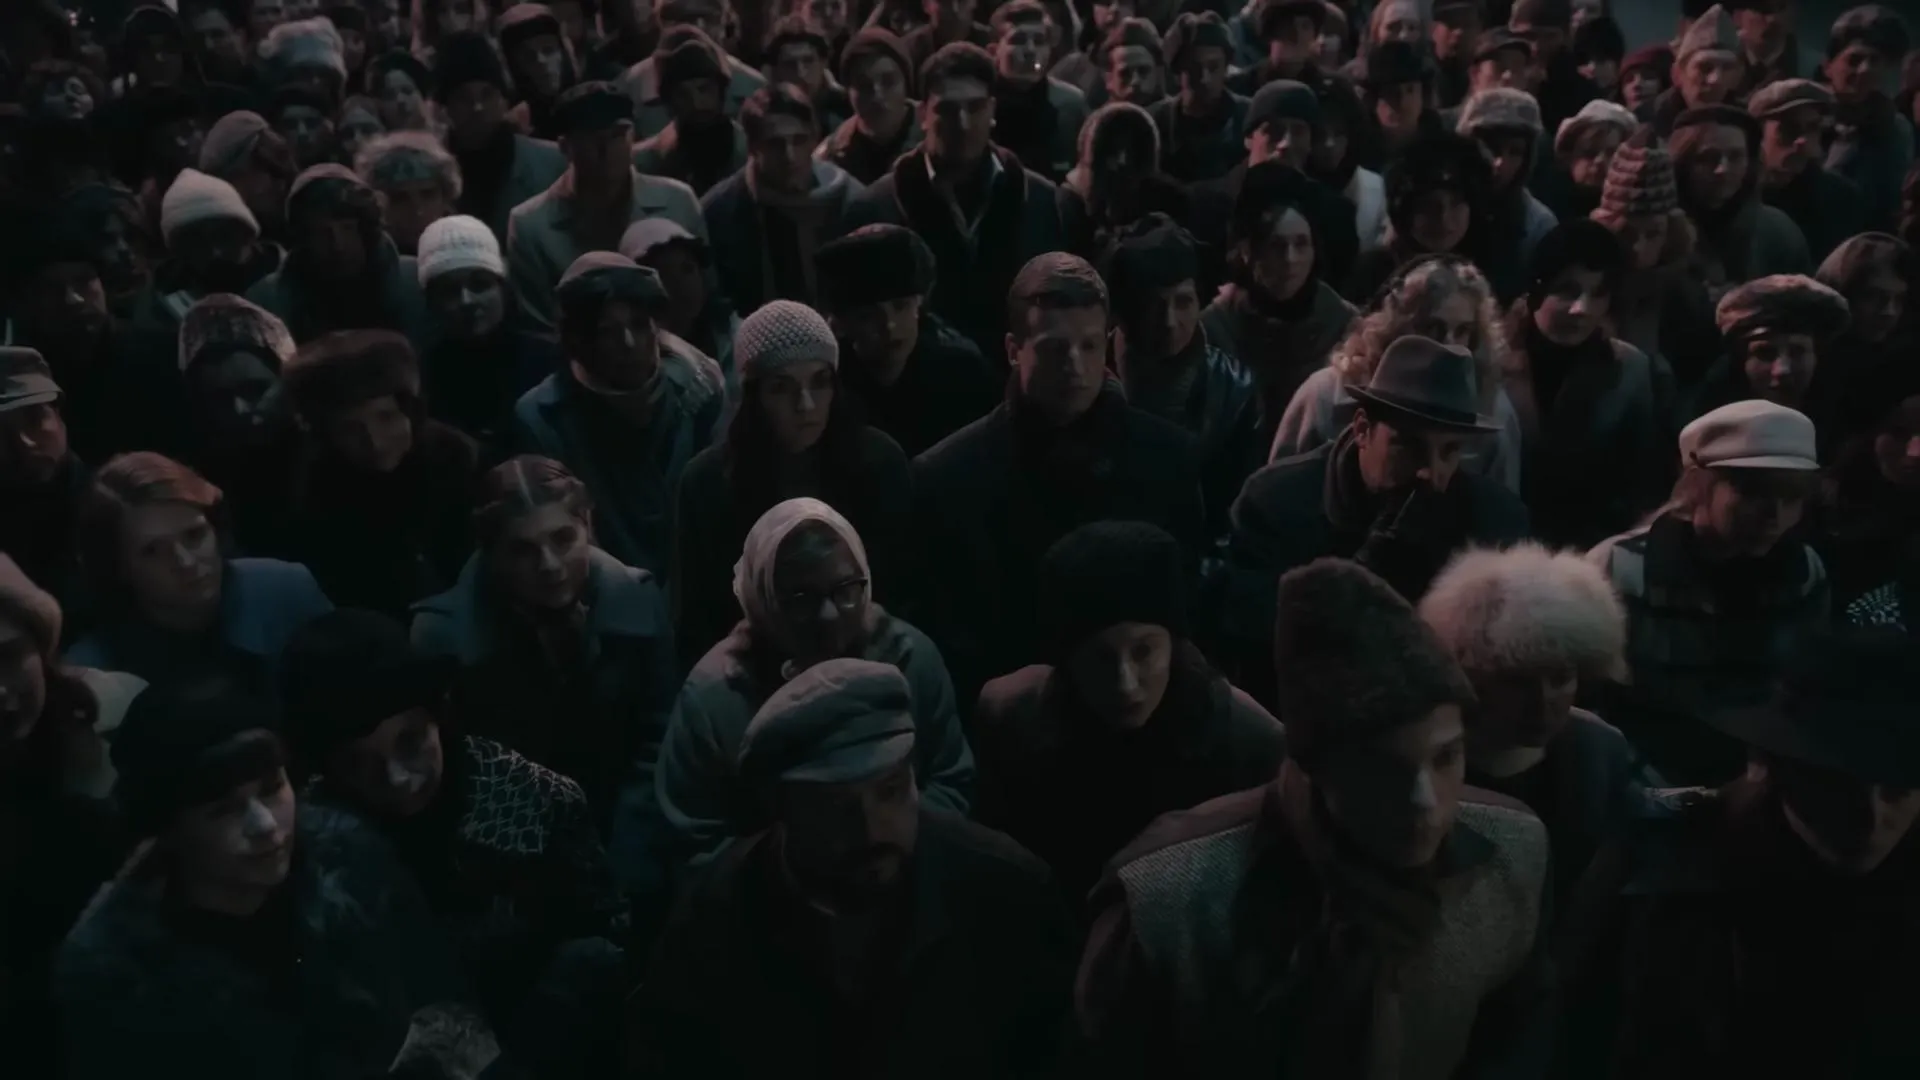
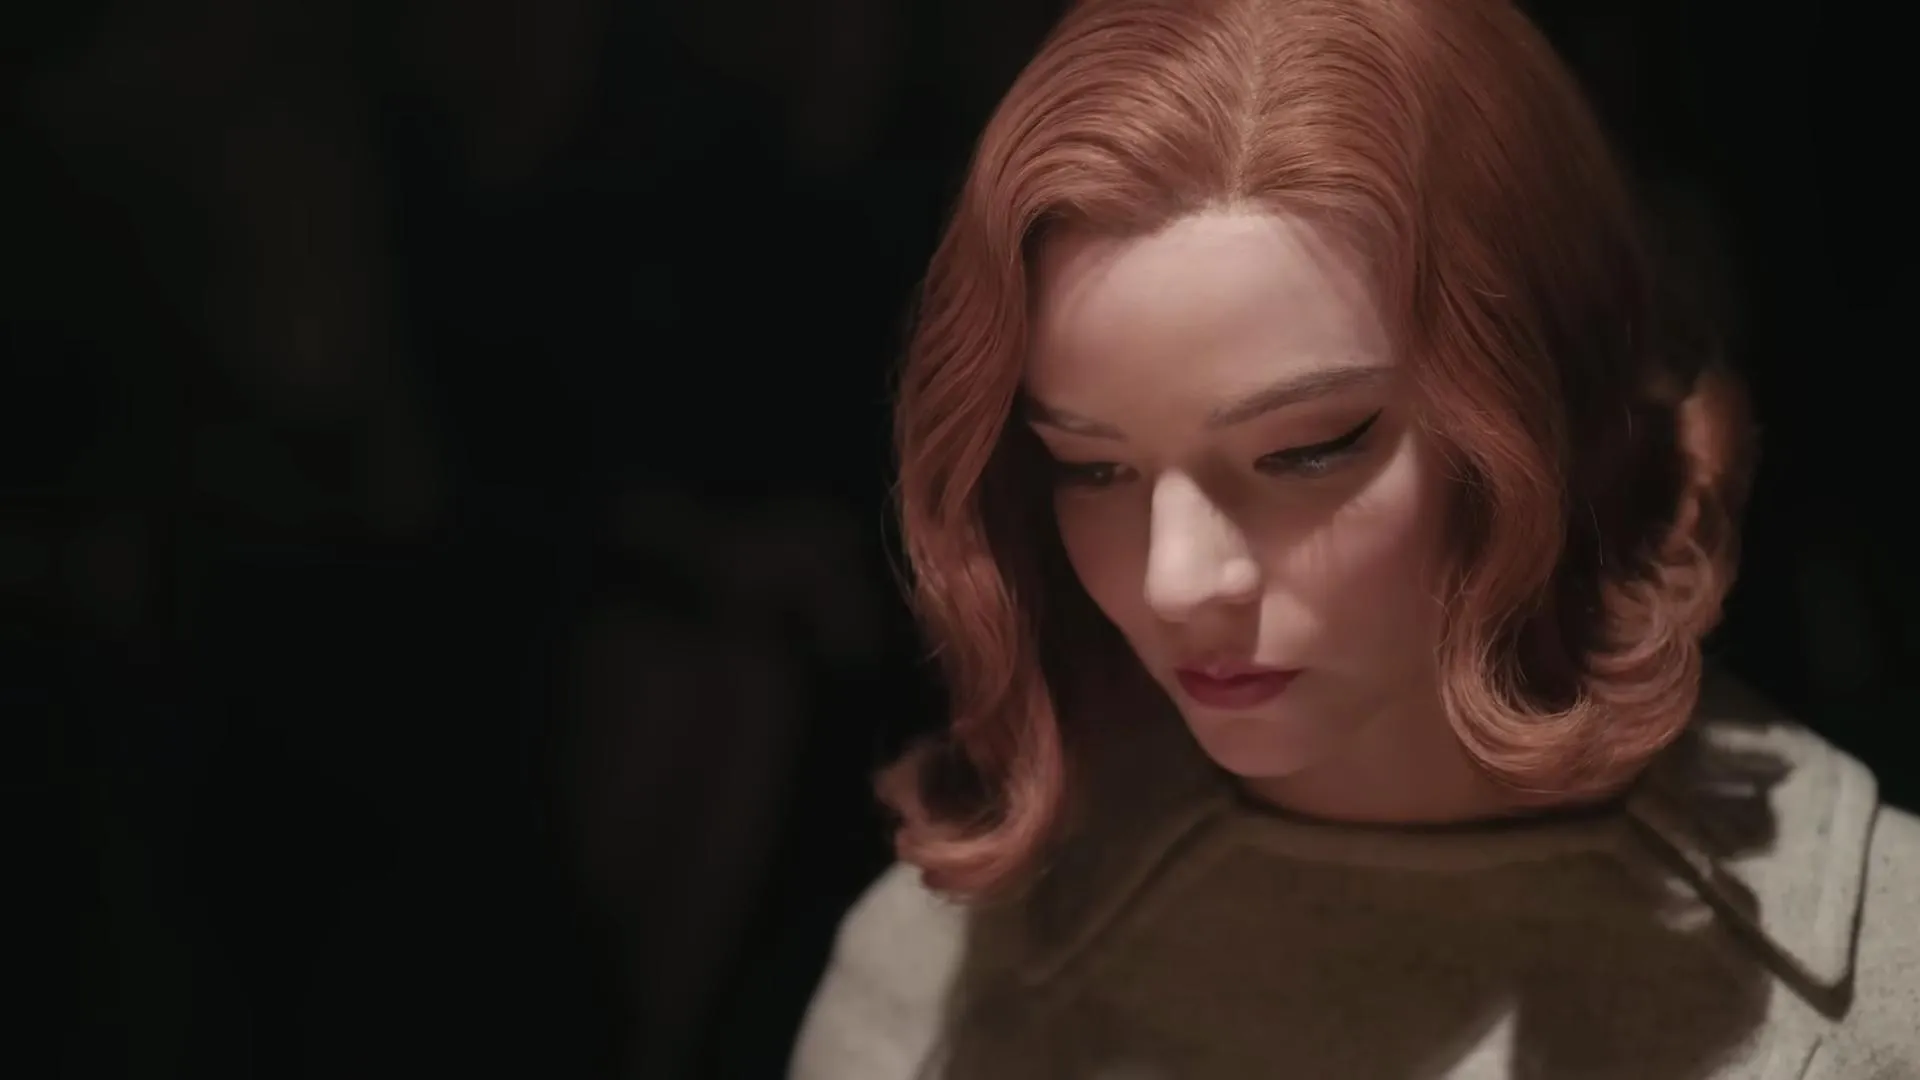
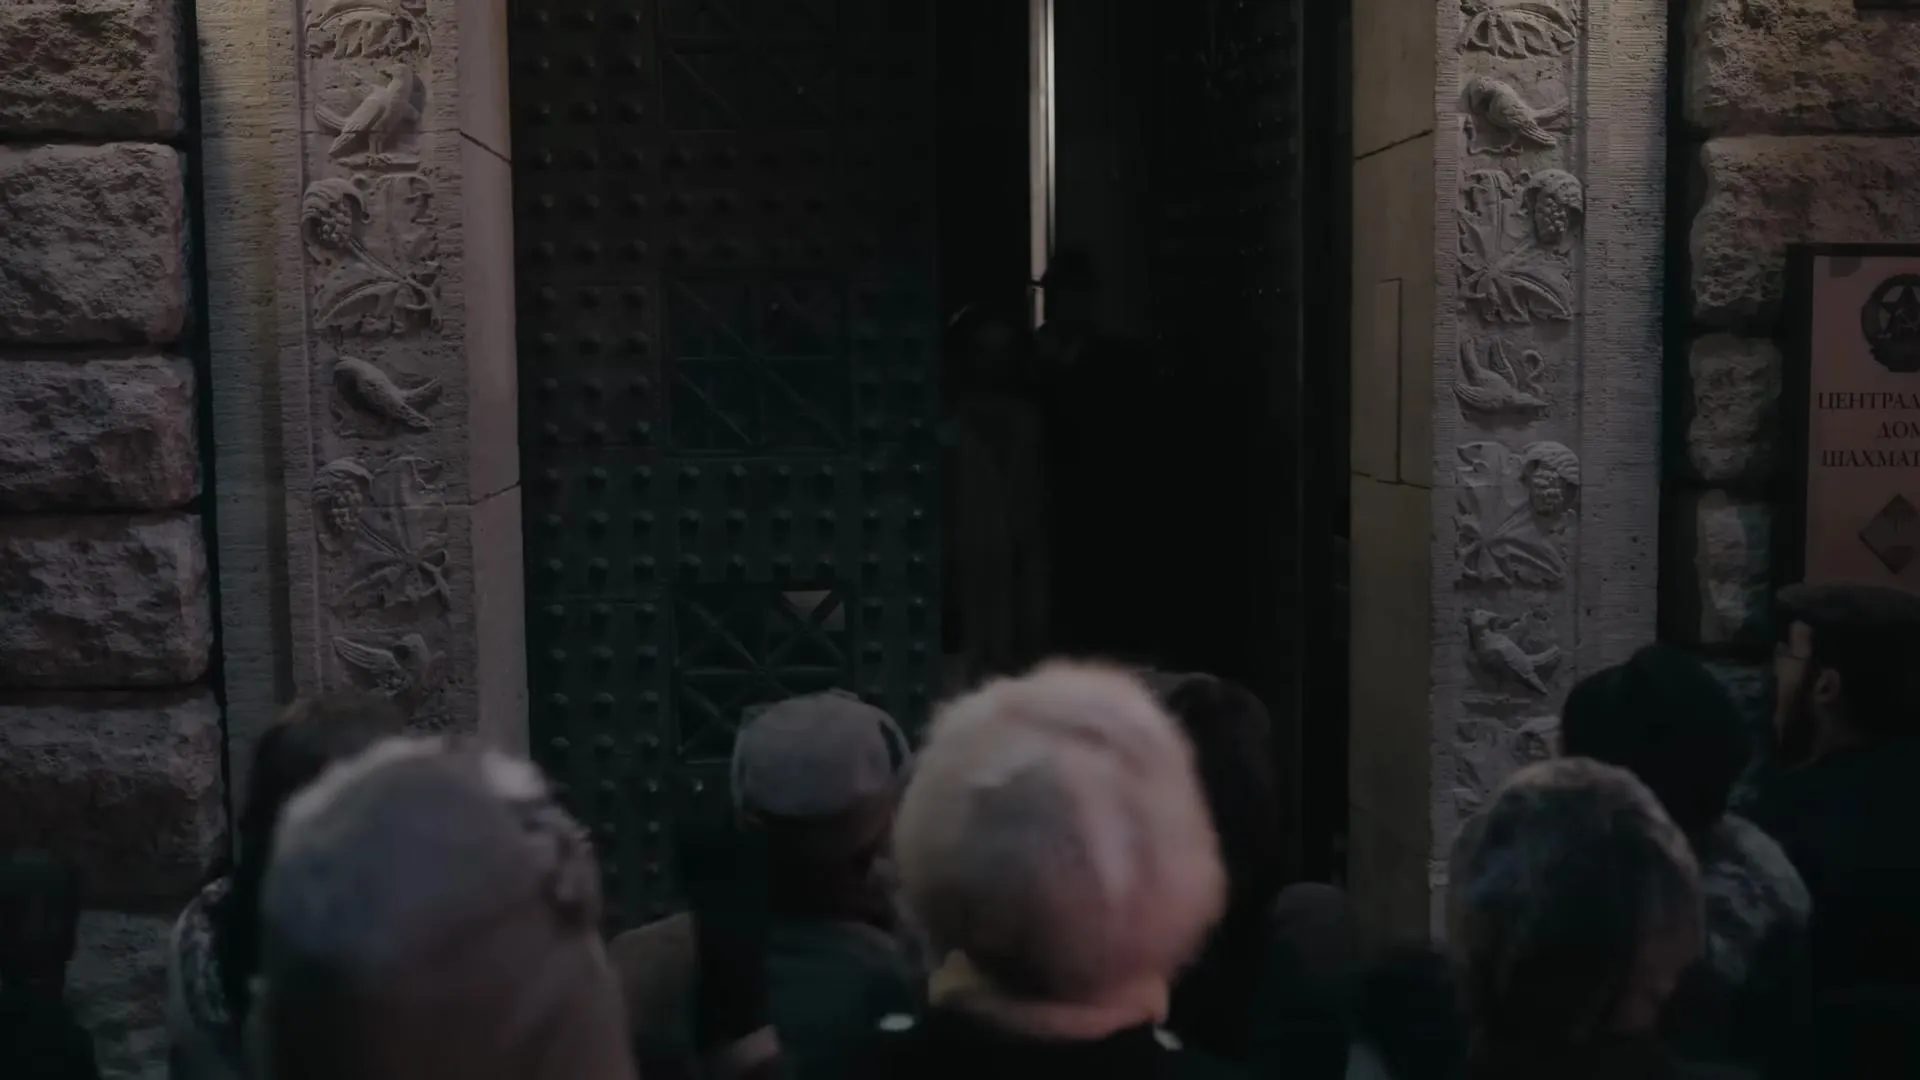

In [33]:
scene_view.select(scene_view.beginning_frame, scene_view.trailer_prompt).limit(3).collect()

If you noticed anything off in the outputs, now would be a great time to edit your prompt generation expression to refine the Gemini output to get it just right. Imagine requiring the prompt to be structured in a specific format, or asking the LLM to include historically accurate details that would make the time period more obvious.

Here are all the prompts we just generated with Gemini:

In [34]:
scene_view.select(
    scene_view.pos,
    scene_view.trailer_prompt
).collect()

pos,trailer_prompt
1,"A sea of solemn faces, illuminated by a single, flickering light. The chill of uncertainty hangs heavy in the air, each breath a silent prayer."
2,"Movie: The Queen's Gambit. Description: A young orphan with a prodigious gift for chess navigates the world of competitive chess while battling personal demons. What is said: No transcript. Close up on a woman's face, bathed in a soft glow, eyes downcast in deep concentration, against a backdrop of stark shadows. Chessboard pieces cast ominous silhouettes."
4,"A crowd gathers outside a dark, ornate stone building, the entrance a foreboding gate. Carvings of birds and fruit adorn the architecture in soft, somber light."
0,"Movie: ""The Accountant"". Description: A forensic accountant uncovers a secret plot while working with a seemingly legitimate company. What is said: ""I never said I was the good guy."" A man in a suit, brow furrowed with intense focus, illuminated only by a single, stark light. Shadows cling to the edges of the frame, hinting at secrets and hidden agendas."
7,"Movie: The Queen's Gambit. Description: In a 1950s orphanage, a young girl reveals an astonishing talent for chess and begins an unlikely journey to stardom while grappling with addiction. This frame is from one scene. What is said: Yes. A young woman in a white coat and beret walks through a park, the overcast sky mirroring the intensity in her gaze. Chess players are scattered in the background."
3,"Silhouette of a woman's face, lit by dim light in a dark room, staring intently. A dusty painting hangs out of focus on the wall beside her."
9,"Movie: ""The Queen's Gambit"". Description: In a 1950s orphanage, a young girl reveals an astonishing talent for chess. Transcript: No transcript available. Close up of a young woman with fiery red hair in a stark white coat and beret, a quiet intensity in her gaze as she prepares her next move. The surrounding crowd fades into a muted blur."
5,"Elegant woman in a checkered coat exits a black car, Moscow skyline glows in the night behind. Shadowy figures surround her, intrigue hanging in the air."
6,"Woman in a white coat steps out of a sleek, black car in a cold, grey European city. Gaunt trees claw at a bone-white sky above an austere building of windows."
8,Snow falls on a Moscow square as a young woman in white is greeted by an old man. His face crinkles with joy as he extends a welcome hand.


## 03 - Create New Content

Now you can generate visual content from your trailer prompts. This section is a "choose your own adventure" style, based on how you want to use your Gemini tokens. At the time of this workshop, the code we provide should keep you safely in the free tier. You have three options:

- **Option A: Generate Images** (faster, cheaper - good for testing) with Gemini's `imagen-4.0-generate-001` model
- **Option B: Generate Videos from Prompt + Image** (slower, more expensive - production quality) with Gemini's `veo-3.1-generate-preview` model
- **Option C: Generate Videos from Image Only** (slower, more expensive - simpler approach) with Gemini's `veo-3.1-generate-preview` model

These examples use `.select().where()` to test generation on a single scene. This is an **query** - it runs once and returns results without storing anything. This is perfect for testing expensive operations before applying them to all rows.

Later, you'll see how to add image generation as a computed column to process all scenes automatically and store the results persistently.

**Note on video generation:** Frames are resized from 1920x1080 to 640x360 before being sent to Gemini. Gemini's API limit for combined text and image data is 100MB per request (recently increased from 20MB). We resize to stay well under this limit.

In Pixeltable, you can chain [`.resize()`](https://docs.pixeltable.com/sdk/latest/image#udf-resize) directly in your expression - you don't have to save the resized image to disk or create a separate column to include it in your API call to Gemini.

### OPTION A: Generate an Image

Test on one scene first. Once you verify the output quality, you can add it as a computed column (see Section 04). Note that you can store the result of this query as `scene_image` - this is an in memory result and does not change your stored table. It is also limited: you can pull this result back up within your Python session only. We'll persist outputs in the next section.

In [35]:
scene_image = scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    scene_view.trailer_prompt,
    trailer_image=pxtf.gemini.generate_images(
        prompt=scene_view.trailer_prompt,
        model='imagen-4.0-generate-001'
    )
).collect()

pos,trailer_prompt,trailer_image
2,"Movie: The Queen's Gambit. Description: A young orphan with a prodigious gift for chess navigates the world of competitive chess while battling personal demons. What is said: No transcript. Close up on a woman's face, bathed in a soft glow, eyes downcast in deep concentration, against a backdrop of stark shadows. Chessboard pieces cast ominous silhouettes.",

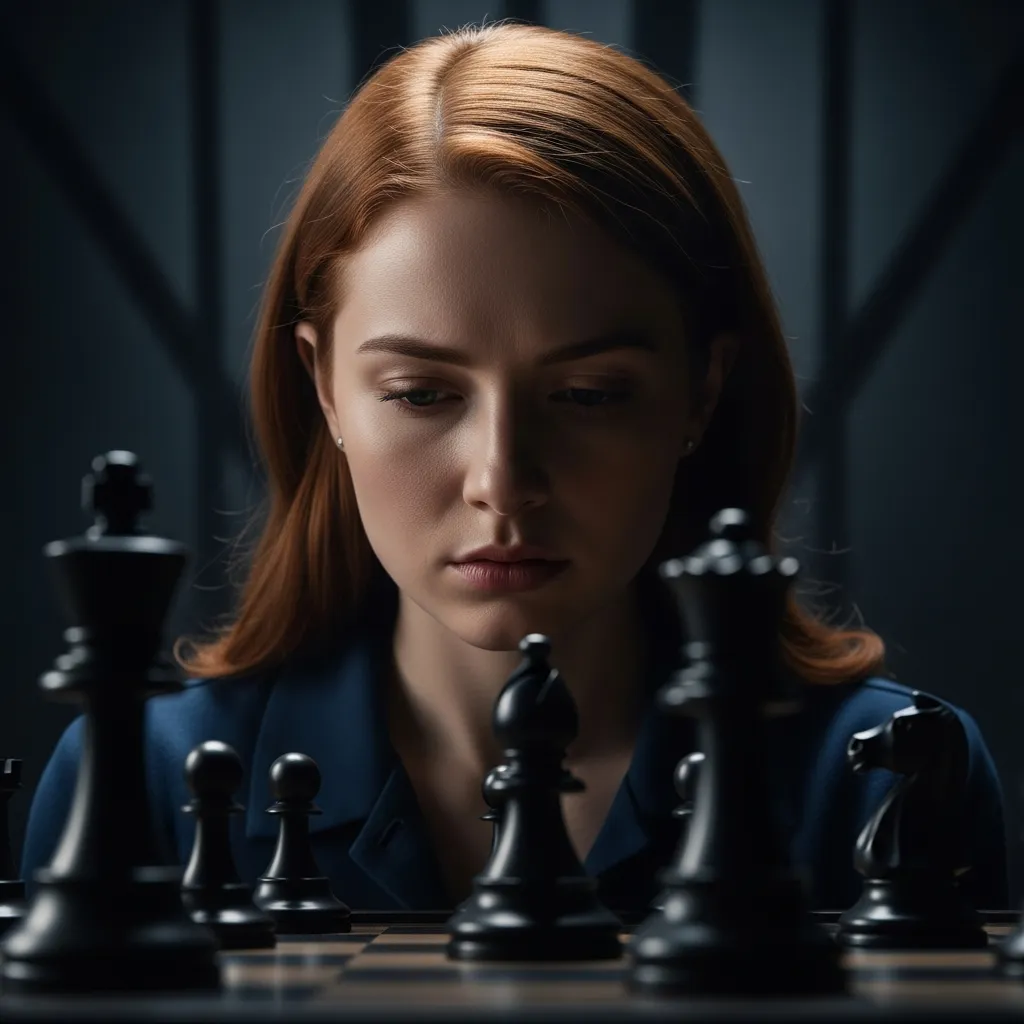

In [36]:
scene_image

### OPTION B: Generate a Video from Prompt + Image

Video generation is slower and more expensive than image generation. This option animates a frame based on your trailer prompt. Again, we'll save the results of this query in memory as `scene_trailer`.

In [37]:
scene_trailer = scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    scene_view.trailer_prompt,
    trailer_video=pxtf.gemini.generate_videos(
        prompt=scene_view.trailer_prompt,
        image=scene_view.beginning_frame.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

pos,trailer_prompt,trailer_video
2,"Movie: The Queen's Gambit. Description: A young orphan with a prodigious gift for chess navigates the world of competitive chess while battling personal demons. What is said: No transcript. Close up on a woman's face, bathed in a soft glow, eyes downcast in deep concentration, against a backdrop of stark shadows. Chessboard pieces cast ominous silhouettes.",

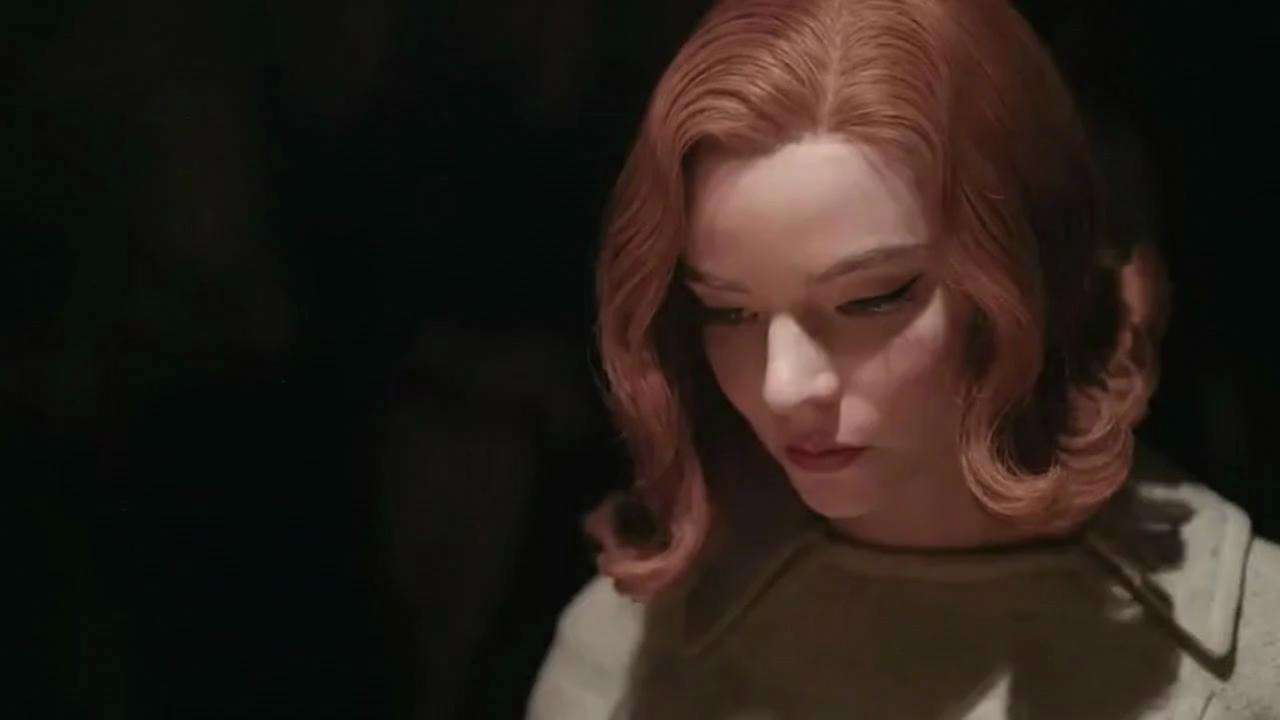

In [64]:
scene_trailer

### OPTION C: Animate an Image (No Prompt)

This simpler approach animates the frame without a text prompt - just the image itself.

In [65]:
scene_animation = scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    animated_video=pxtf.gemini.generate_videos(
        image=scene_view.beginning_frame.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

pos,animated_video
2,

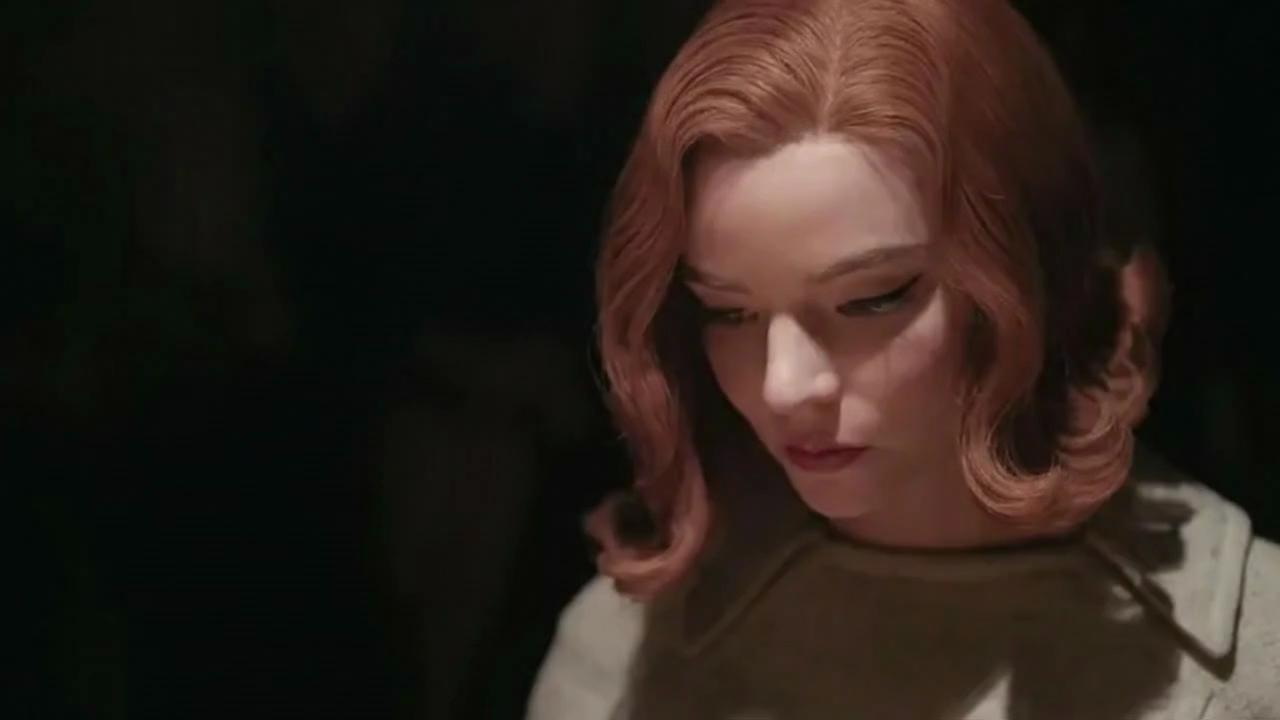

In [66]:
scene_animation

You've tested image and video generation on individual scenes in queries using `.select().where()`. 

But what if you want to generate images for **all** scenes automatically, and save them persistently in your view table?

## 04 - Generate Across All Scenes

You've tested image generation on a single scene using `.select().where()`. Now you'll add it as a computed column to process all scenes automatically.

**What changes when you use a computed column:**

1. **Processes all rows**: Generates images for all 10 scenes without loops or iteration code
2. **Parallel execution**: Pixeltable parallelizes API calls automatically - faster than sequential processing
3. **Persistent storage**: Results are stored in the table, not just returned as query results
4. **Incremental updates**: If you add new videos to the base table, the scene detection and image generation cascade automatically

Here we will generate just images with the `imagen-4.0-generate-001` model. At the time of this workshop, Gemini limits this model to 10 requests per minute, so you can run this code on all 10 rows within the free tier.

If you want to test out video generation and have your billing setup, you can adapt our query code above to use computed columns instead. You'll want to configure Pixeltable with provider-specific rate limits: https://docs.pixeltable.com/platform/configuration#rate-limit-configuration

This computed column will automatically generate trailer images for all 10 scenes - it takes just under a minute to execute:

In [70]:
scene_view.add_computed_column(
    trailer_image=pxtf.gemini.generate_images(
        prompt=scene_view.trailer_prompt,
        model='imagen-4.0-generate-001'
    ),
    if_exists='replace',
    on_error='ignore'
)

Added 10 column values with 1 error in 52.38 s (0.19 rows/s)


10 rows updated, 1 exception.

**What happens when you execute this code:**

We've created a **declarative workflow** with three computed columns that form a processing pipeline:

1. `beginning_frame` - Extracts a frame from each video segment
2. `trailer_prompt` - Generates a text description from the frame (multimodal AI)
3. `trailer_image` - Generates an image from the text description (text-to-image AI)

Each computed column builds on the previous one. Pixeltable handles the orchestration - it knows the dependencies and executes them in the correct order automatically.

Let's take a look at our collection of generated images:

pos,trailer_prompt,trailer_image
1,"A sea of solemn faces, illuminated by a single, flickering light. The chill of uncertainty hangs heavy in the air, each breath a silent prayer.",
2,"Movie: The Queen's Gambit. Description: A young orphan with a prodigious gift for chess navigates the world of competitive chess while battling personal demons. What is said: No transcript. Close up on a woman's face, bathed in a soft glow, eyes downcast in deep concentration, against a backdrop of stark shadows. Chessboard pieces cast ominous silhouettes.",None
4,"A crowd gathers outside a dark, ornate stone building, the entrance a foreboding gate. Carvings of birds and fruit adorn the architecture in soft, somber light.",
0,"Movie: ""The Accountant"". Description: A forensic accountant uncovers a secret plot while working with a seemingly legitimate company. What is said: ""I never said I was the good guy."" A man in a suit, brow furrowed with intense focus, illuminated only by a single, stark light. Shadows cling to the edges of the frame, hinting at secrets and hidden agendas.",
7,"Movie: The Queen's Gambit. Description: In a 1950s orphanage, a young girl reveals an astonishing talent for chess and begins an unlikely journey to stardom while grappling with addiction. This frame is from one scene. What is said: Yes. A young woman in a white coat and beret walks through a park, the overcast sky mirroring the intensity in her gaze. Chess players are scattered in the background.",
3,"Silhouette of a woman's face, lit by dim light in a dark room, staring intently. A dusty painting hangs out of focus on the wall beside her.",
9,"Movie: ""The Queen's Gambit"". Description: In a 1950s orphanage, a young girl reveals an astonishing talent for chess. Transcript: No transcript available. Close up of a young woman with fiery red hair in a stark white coat and beret, a quiet intensity in her gaze as she prepares her next move. The surrounding crowd fades into a muted blur.",
5,"Elegant woman in a checkered coat exits a black car, Moscow skyline glows in the night behind. Shadowy figures surround her, intrigue hanging in the air.",
6,"Woman in a white coat steps out of a sleek, black car in a cold, grey European city. Gaunt trees claw at a bone-white sky above an austere building of windows.",
8,Snow falls on a Moscow square as a young woman in white is greeted by an old man. His face crinkles with joy as he extends a welcome hand.,

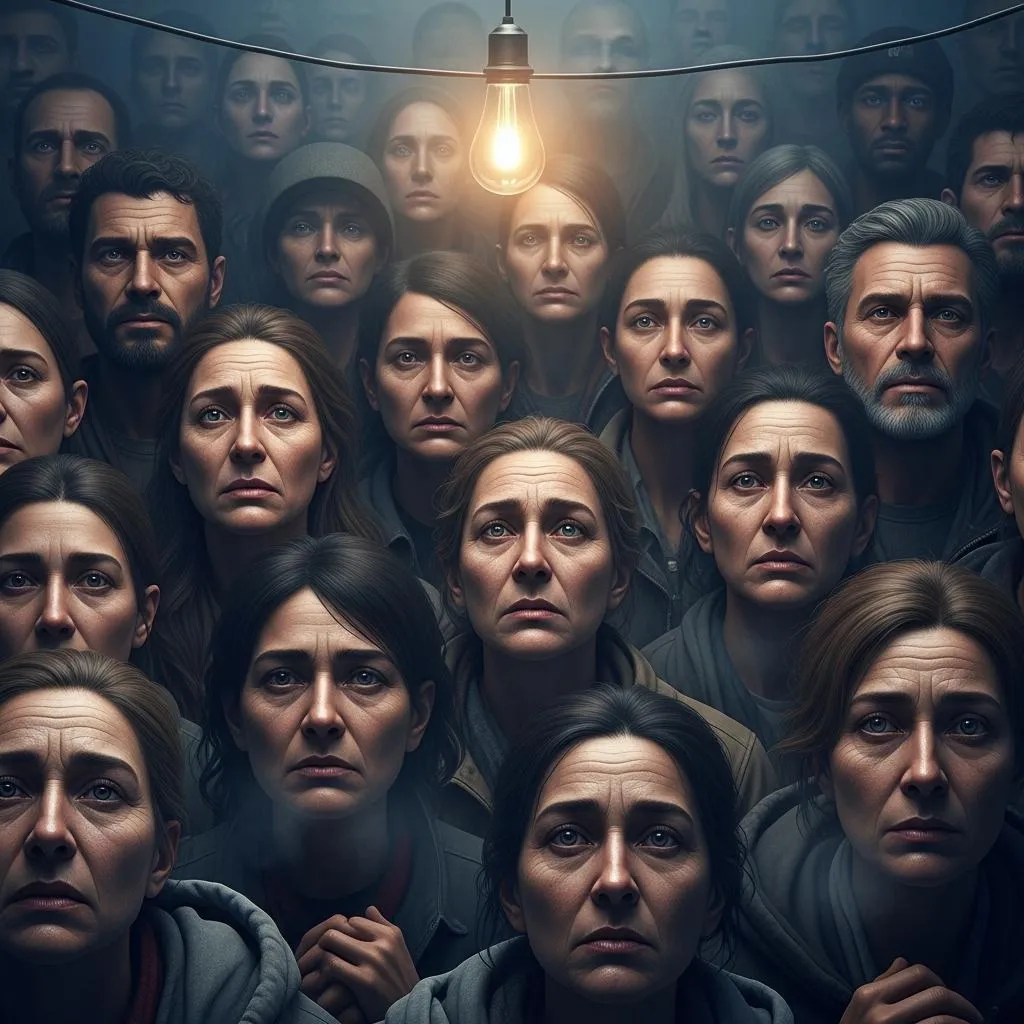
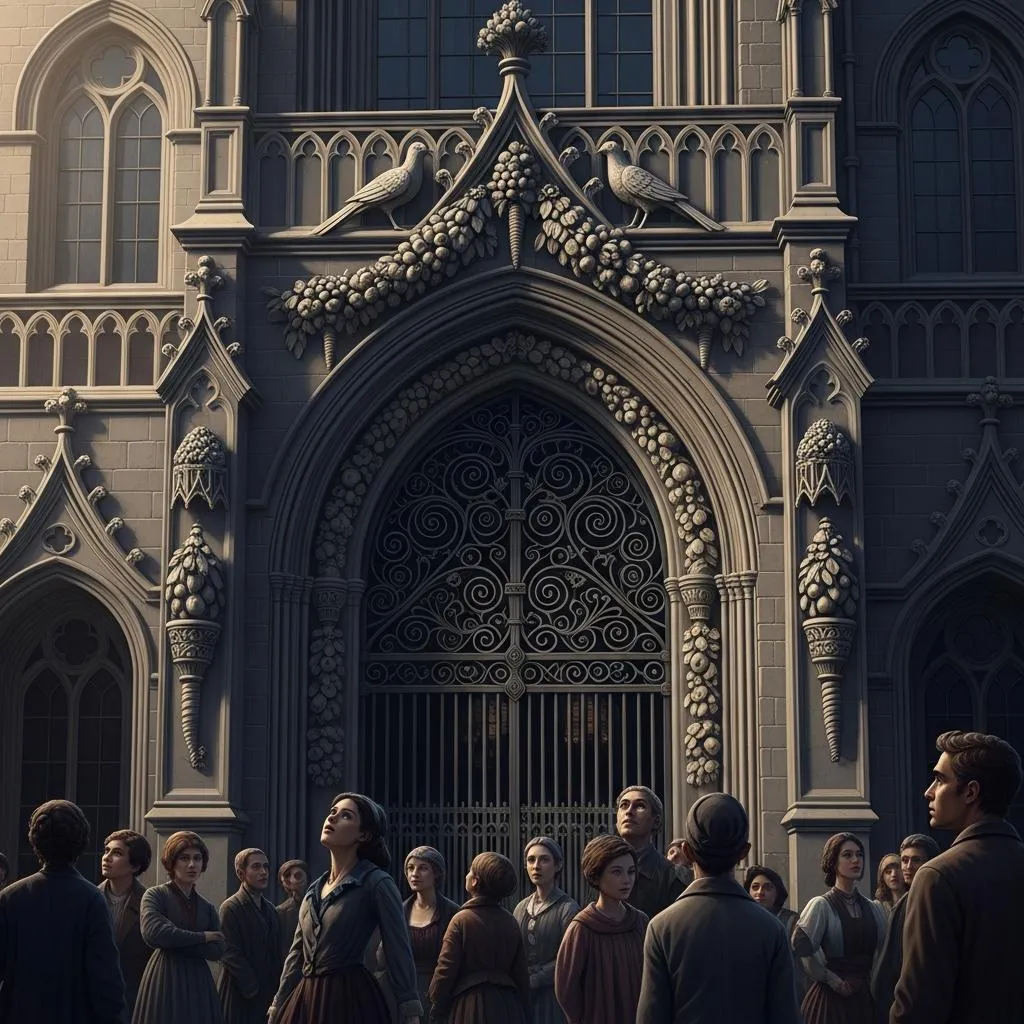
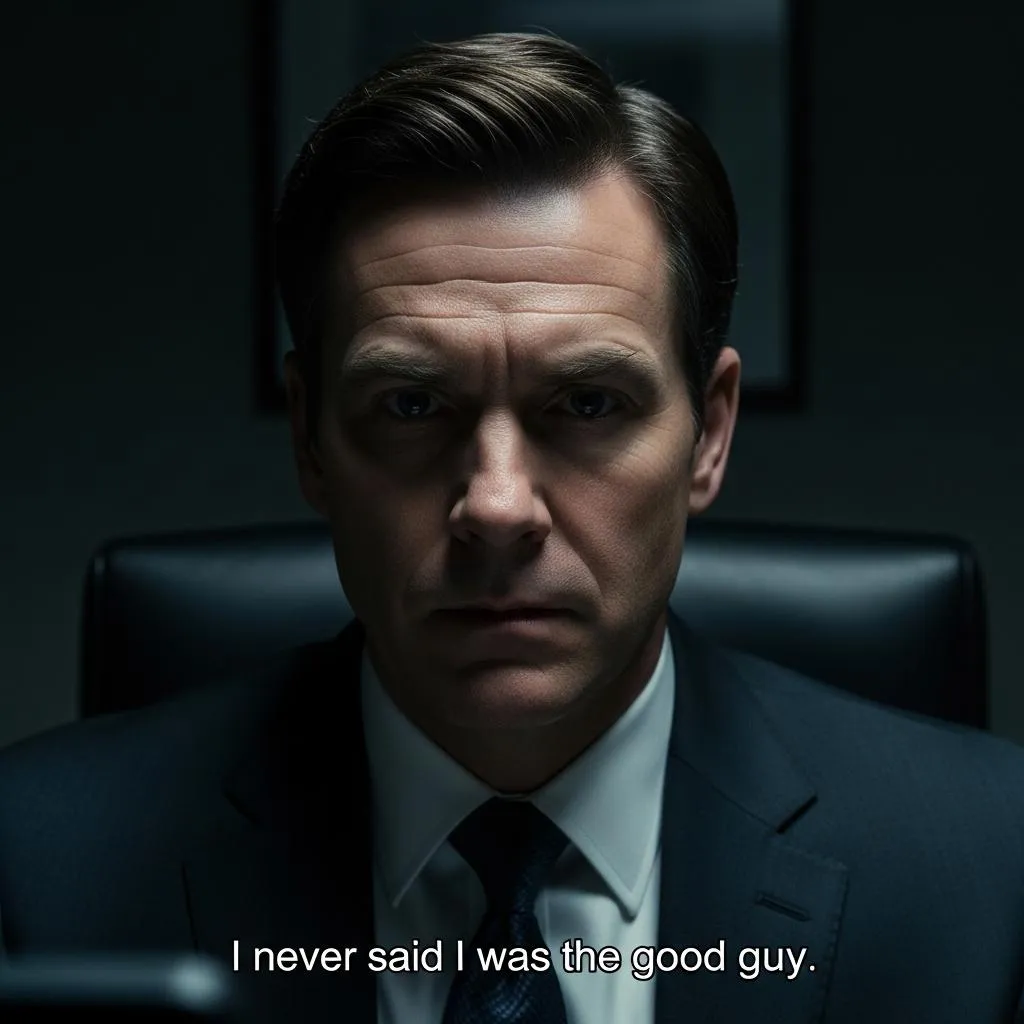
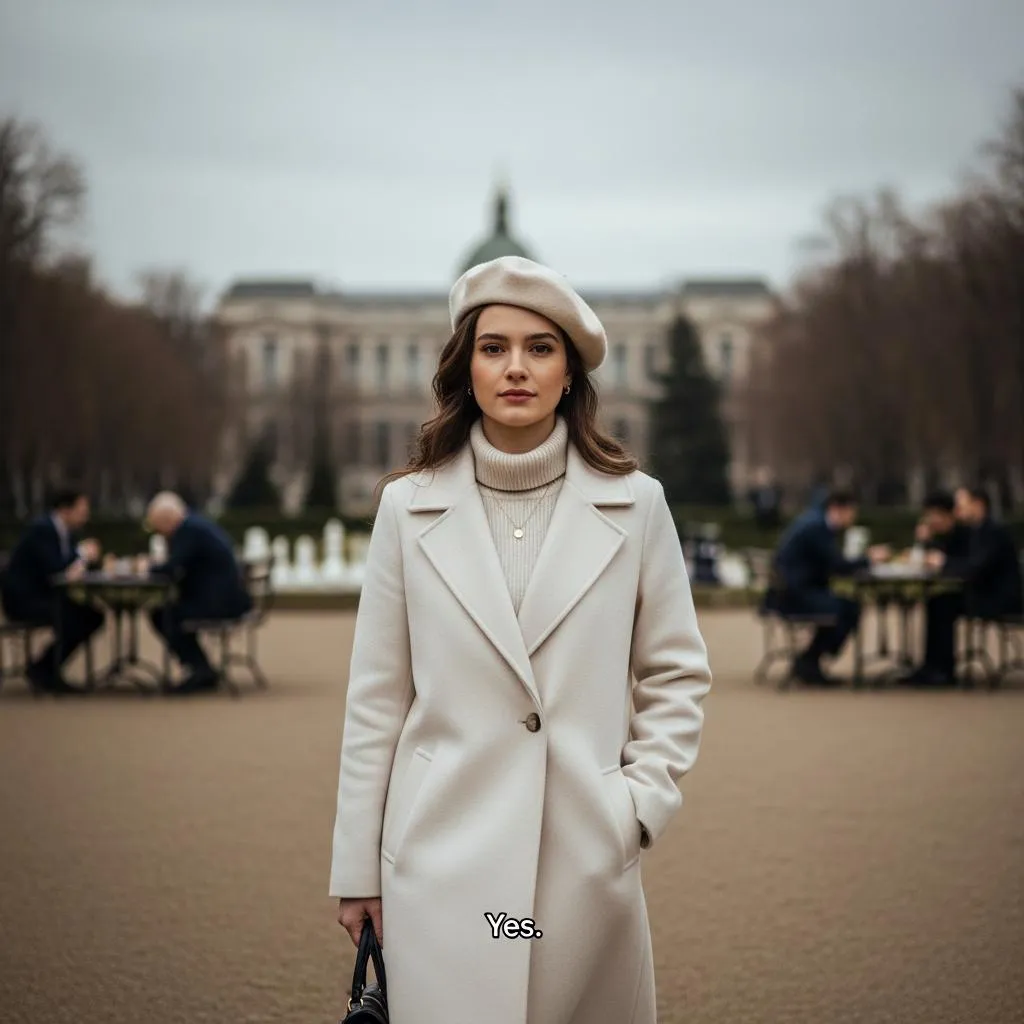
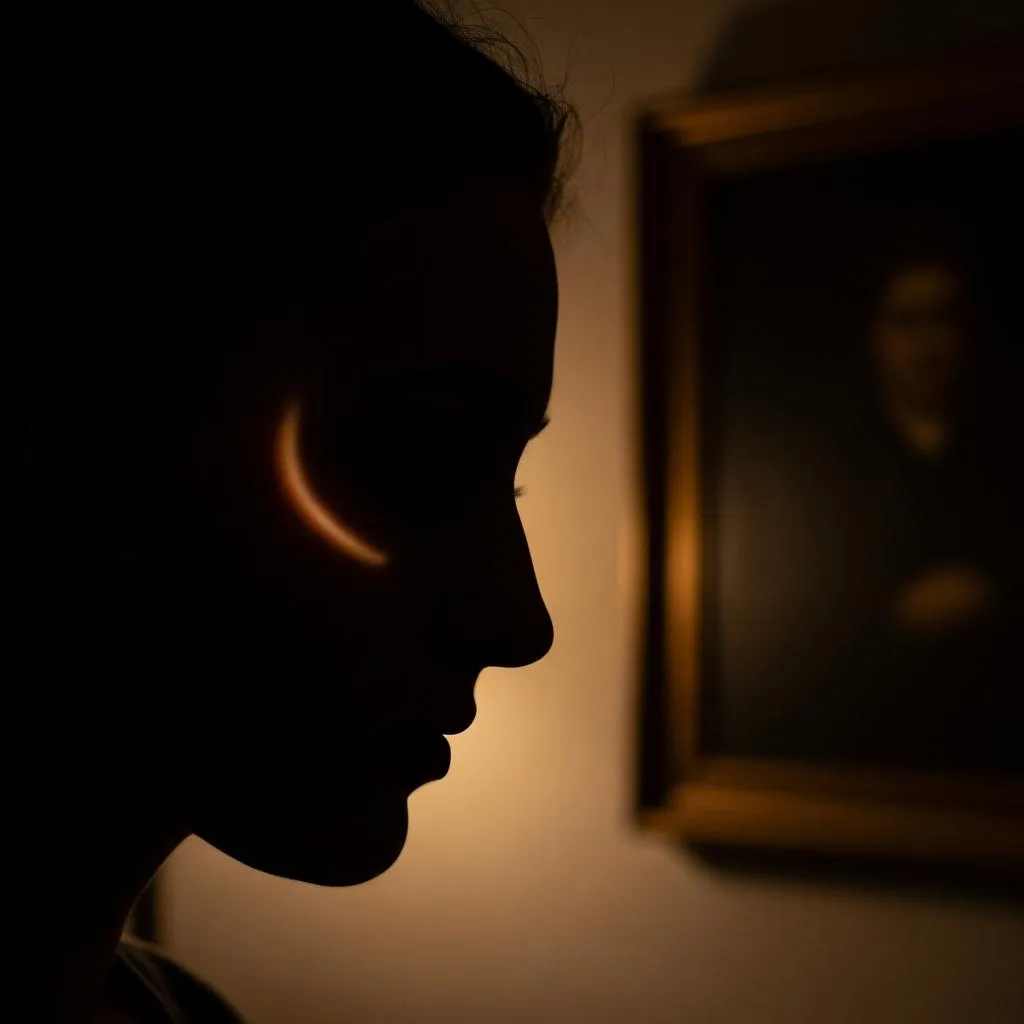
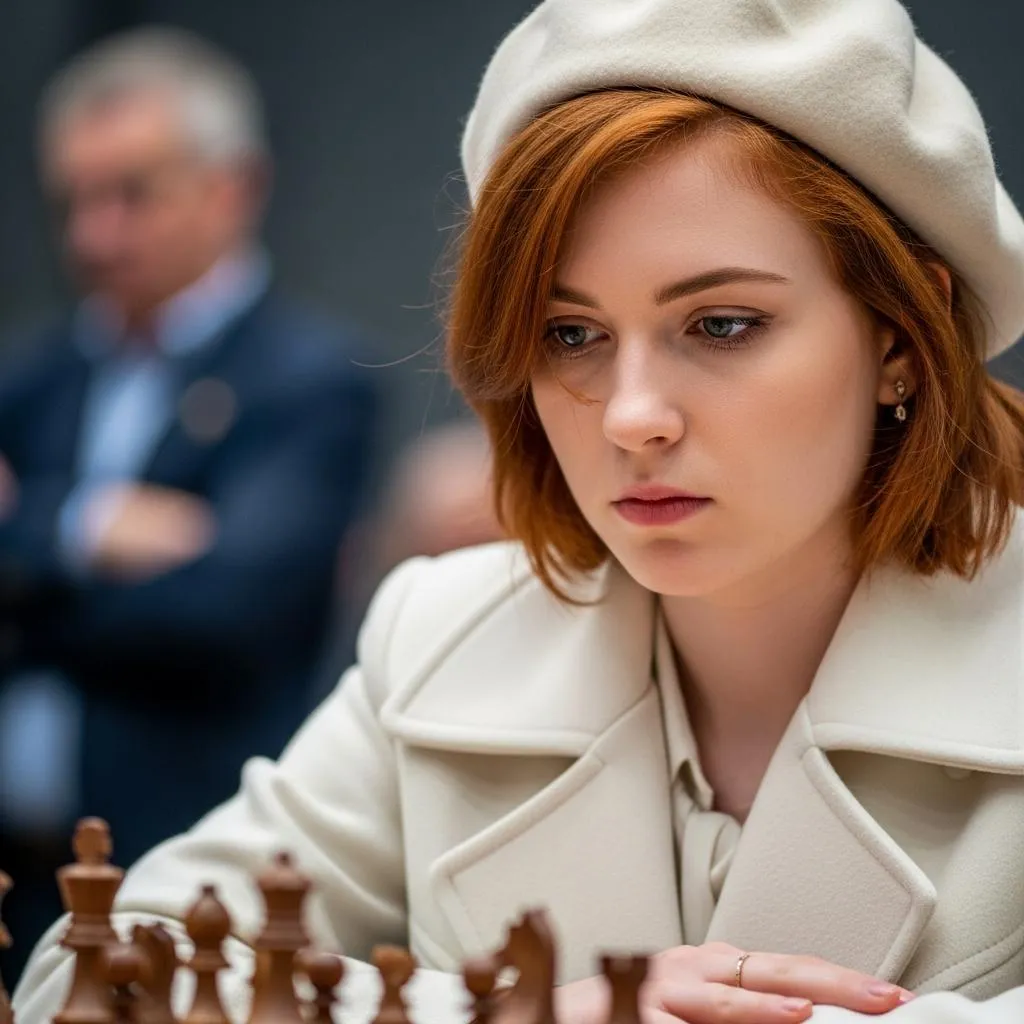
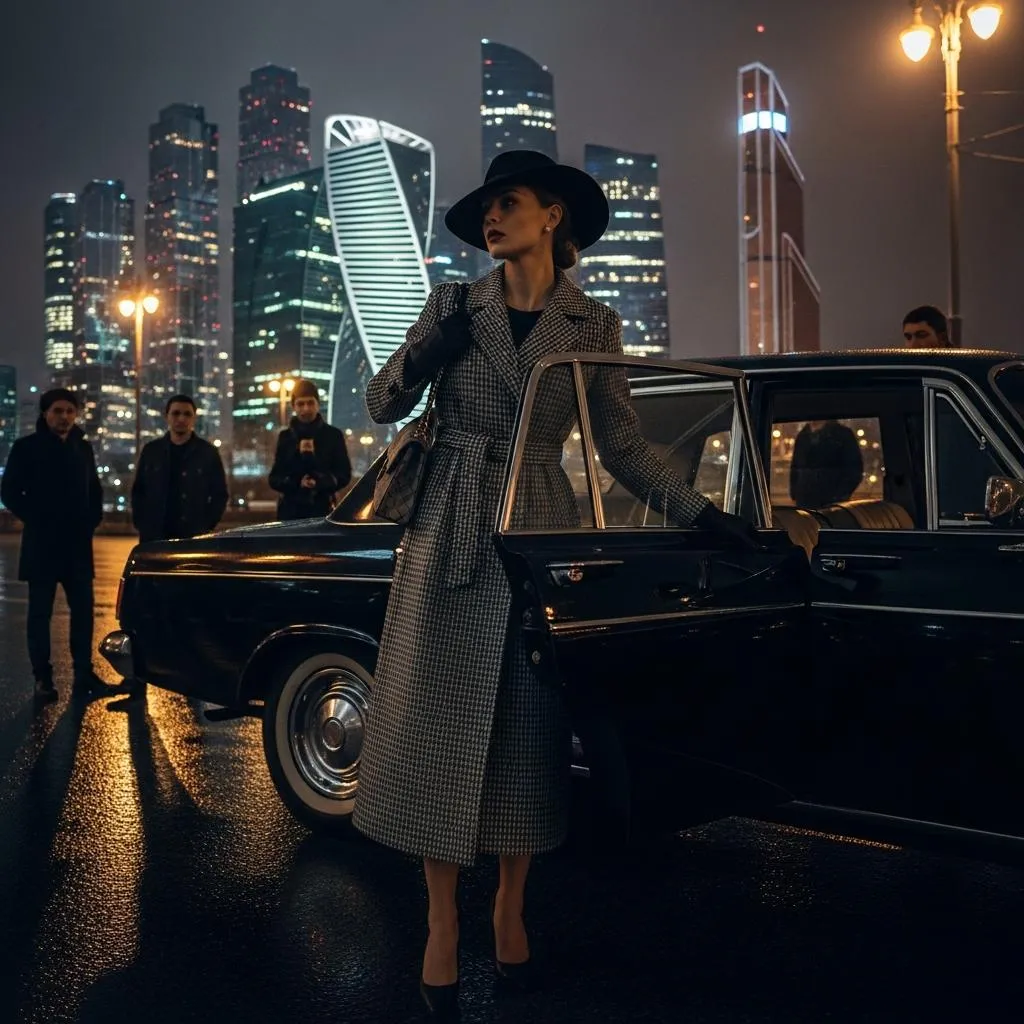
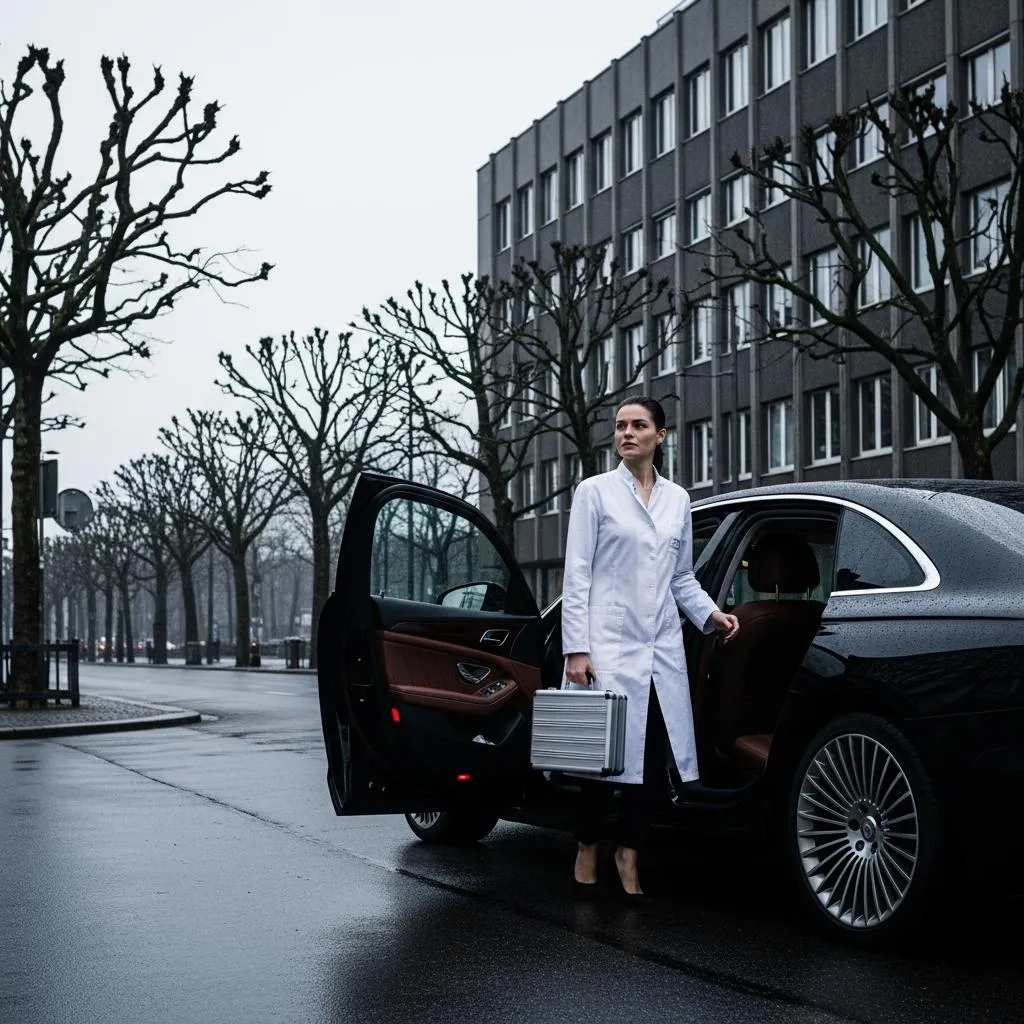
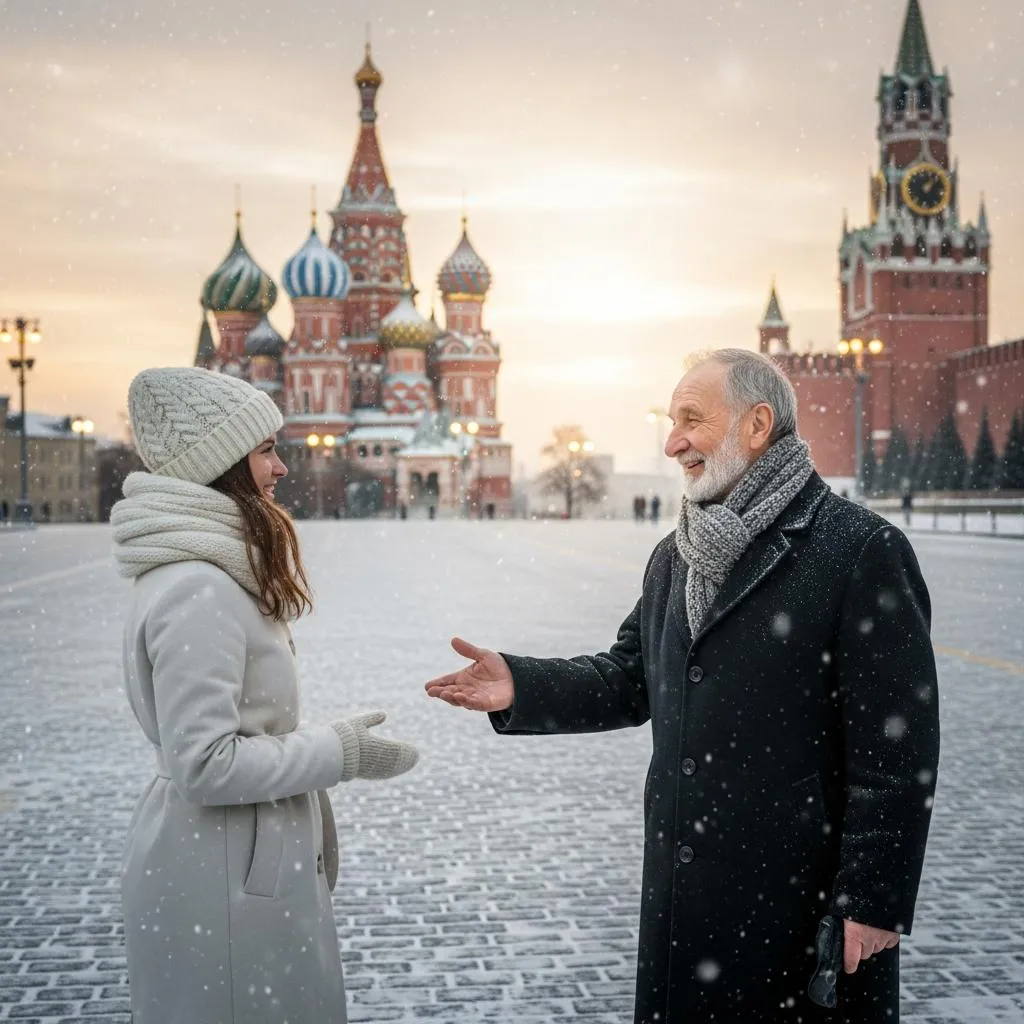

In [71]:
scene_view.select(
    scene_view.pos,
    scene_view.trailer_prompt,
    scene_view.trailer_image
).collect()

Now that these are stored persistently, you can see the images have a spot in your local file cache. Read more about external files in our docs: https://docs.pixeltable.com/platform/external-files

trailer_image,trailer_image_localpath
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/95/95e1/57fa38f51e4842d7abd1b2c90723870d_32_43_95e124e255c44ab0ae621ed0e9b2ac55.jpeg
None,NaN
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/b9/b92c/57fa38f51e4842d7abd1b2c90723870d_32_43_b92c694cce9c40cc84535fb0e2a2da01.jpeg
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/30/30db/57fa38f51e4842d7abd1b2c90723870d_32_43_30dbb83760de4266be2de6319a7eb7e2.jpeg
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/b4/b4d3/57fa38f51e4842d7abd1b2c90723870d_32_43_b4d3911d22244a2786e1268cdc9e4f7b.jpeg
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/e7/e7ae/57fa38f51e4842d7abd1b2c90723870d_32_43_e7aea2634e584557a34ab1065e129d96.jpeg
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/db/db4d/57fa38f51e4842d7abd1b2c90723870d_32_43_db4dee3732824fcab9da2a7f87e4dd51.jpeg
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/2a/2ad2/57fa38f51e4842d7abd1b2c90723870d_32_43_2ad22a3b0d4b420ea703987f053b0096.jpeg
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/98/98cc/57fa38f51e4842d7abd1b2c90723870d_32_43_98ccf5de941f48b5b45cebe41888a7a5.jpeg
,/Users/alison-pxt/.pixeltable/media/57fa38f51e4842d7abd1b2c90723870d/2e/2ec0/57fa38f51e4842d7abd1b2c90723870d_32_43_2ec0051c6f1046868f008dac8a0dda36.jpeg

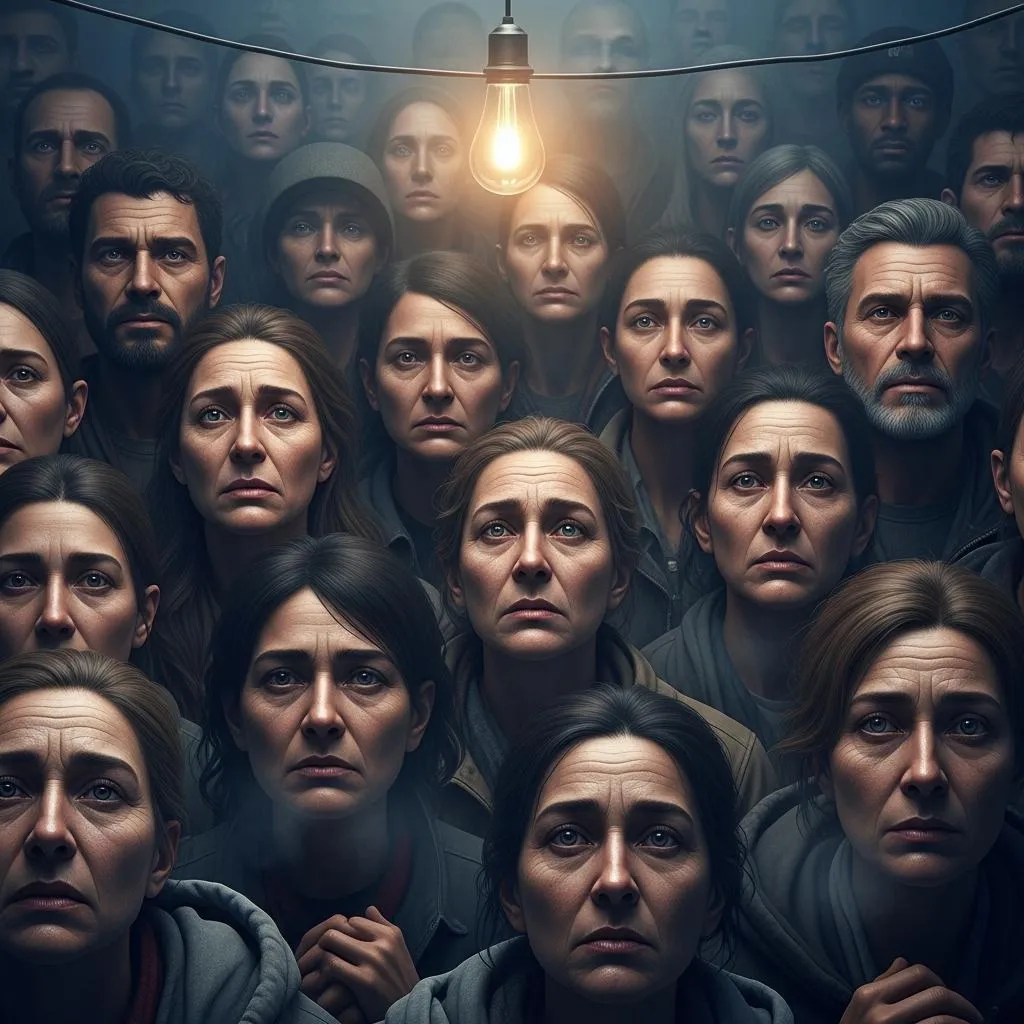
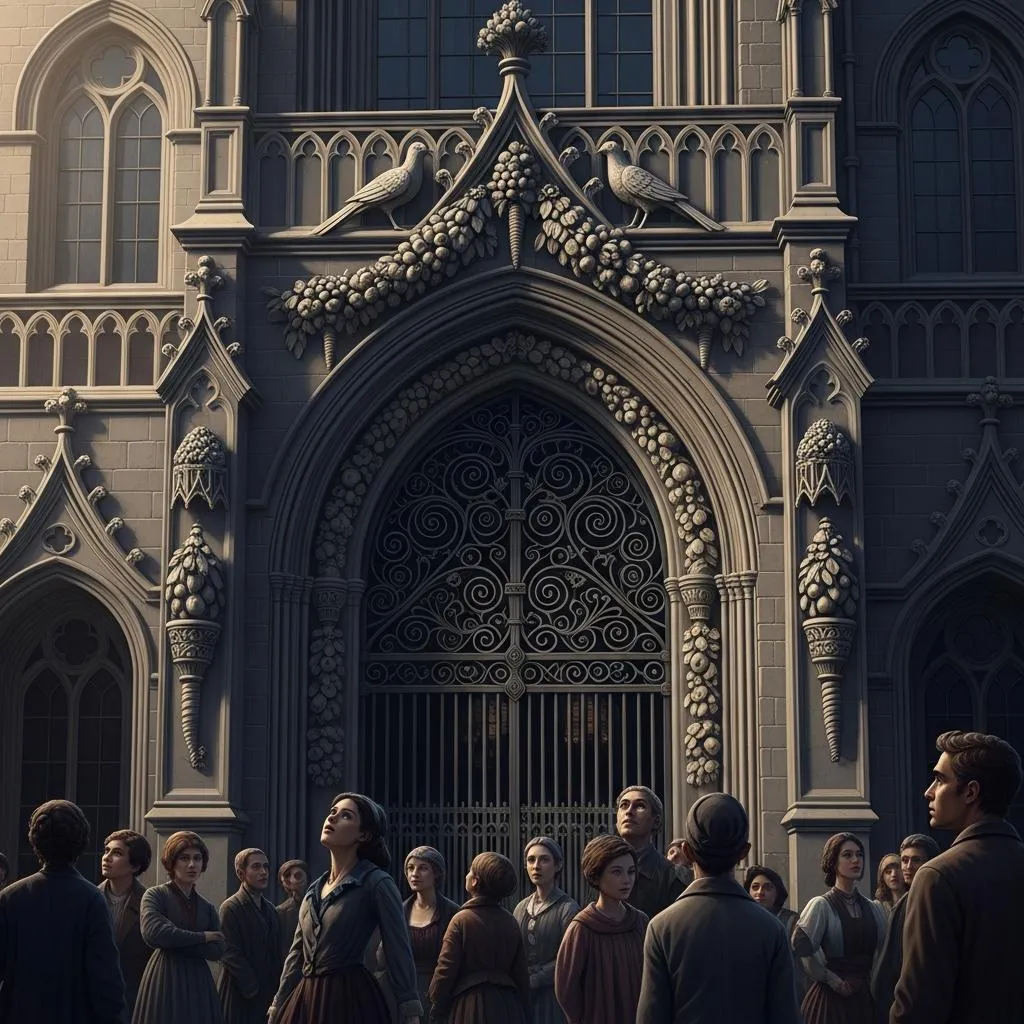
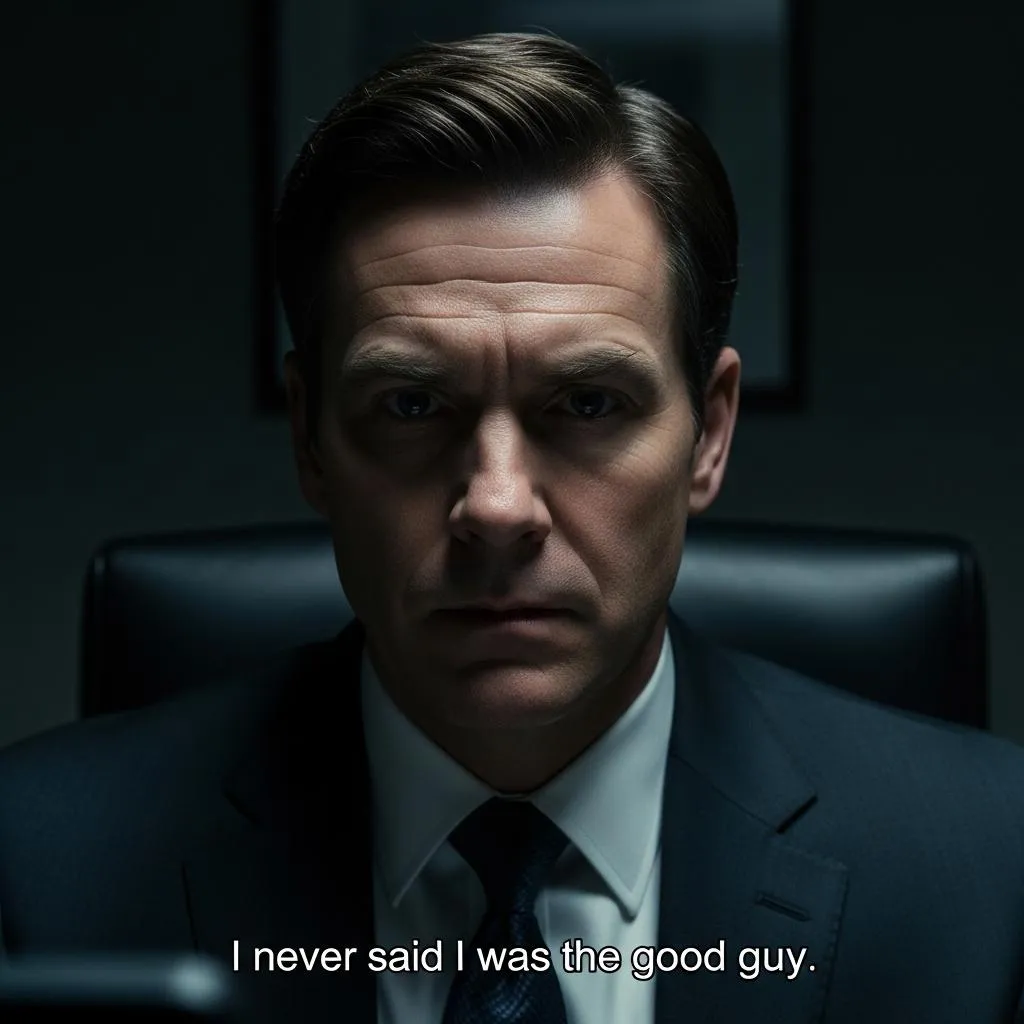
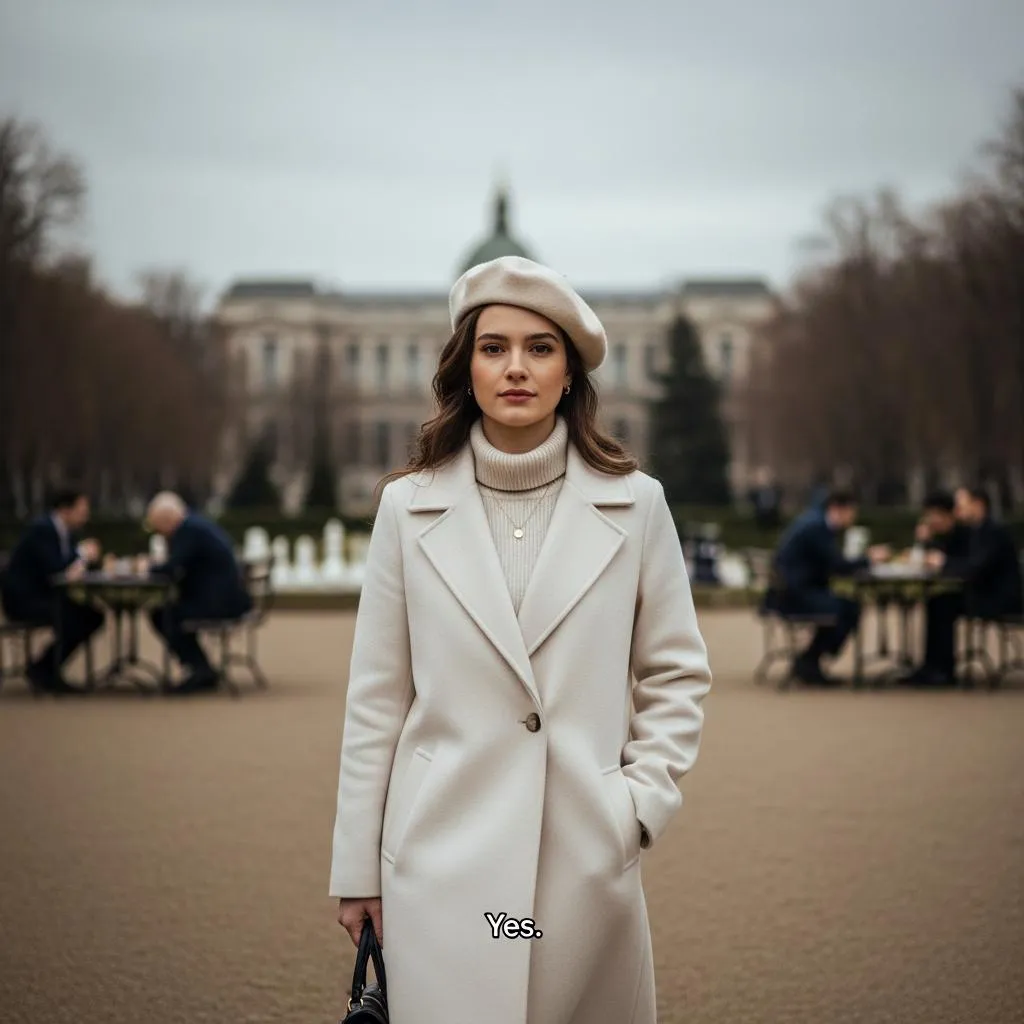
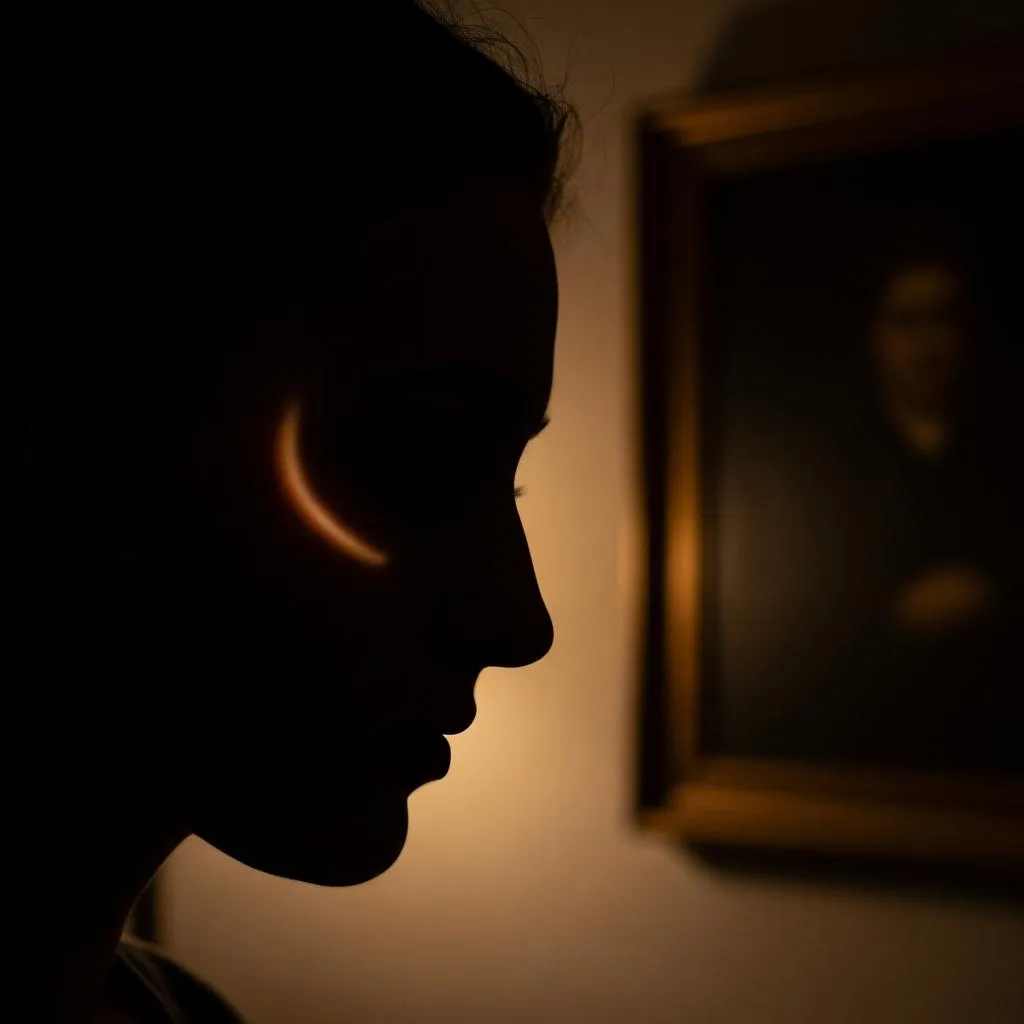
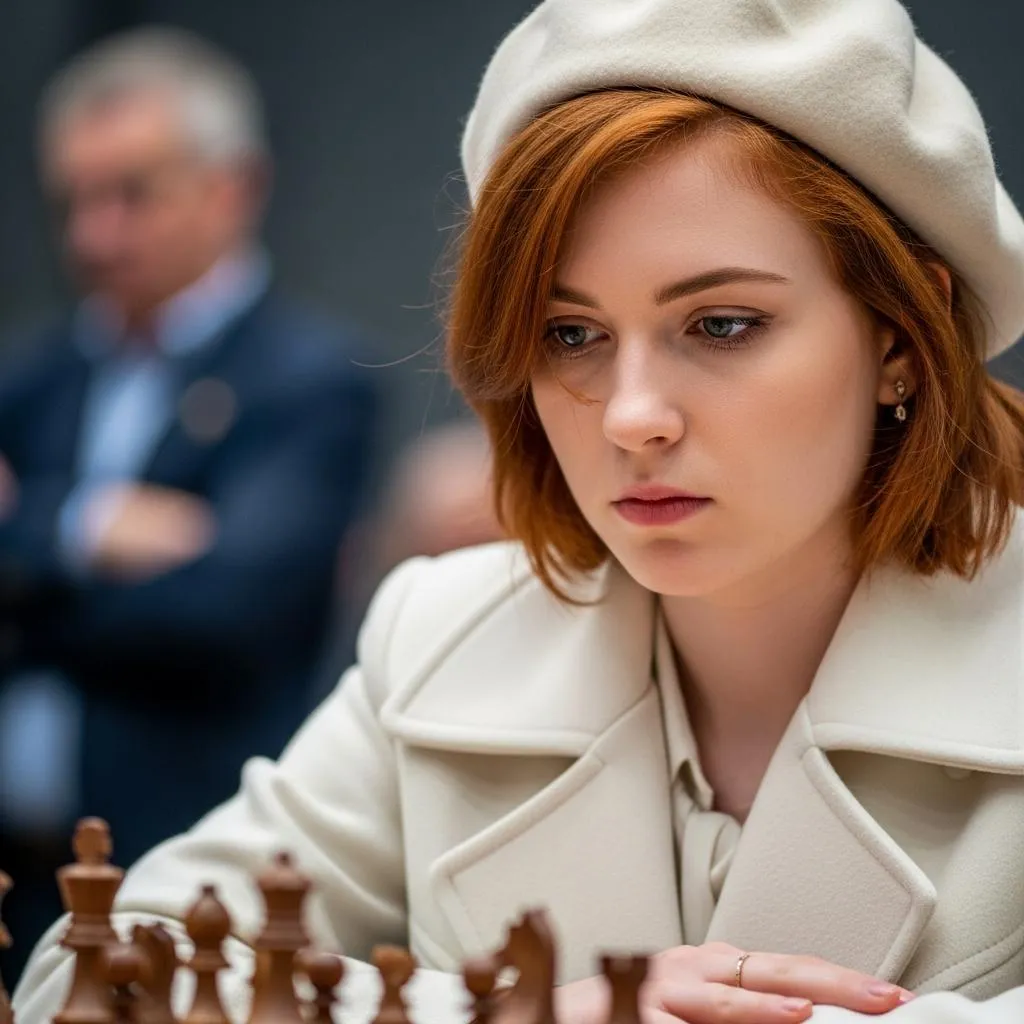
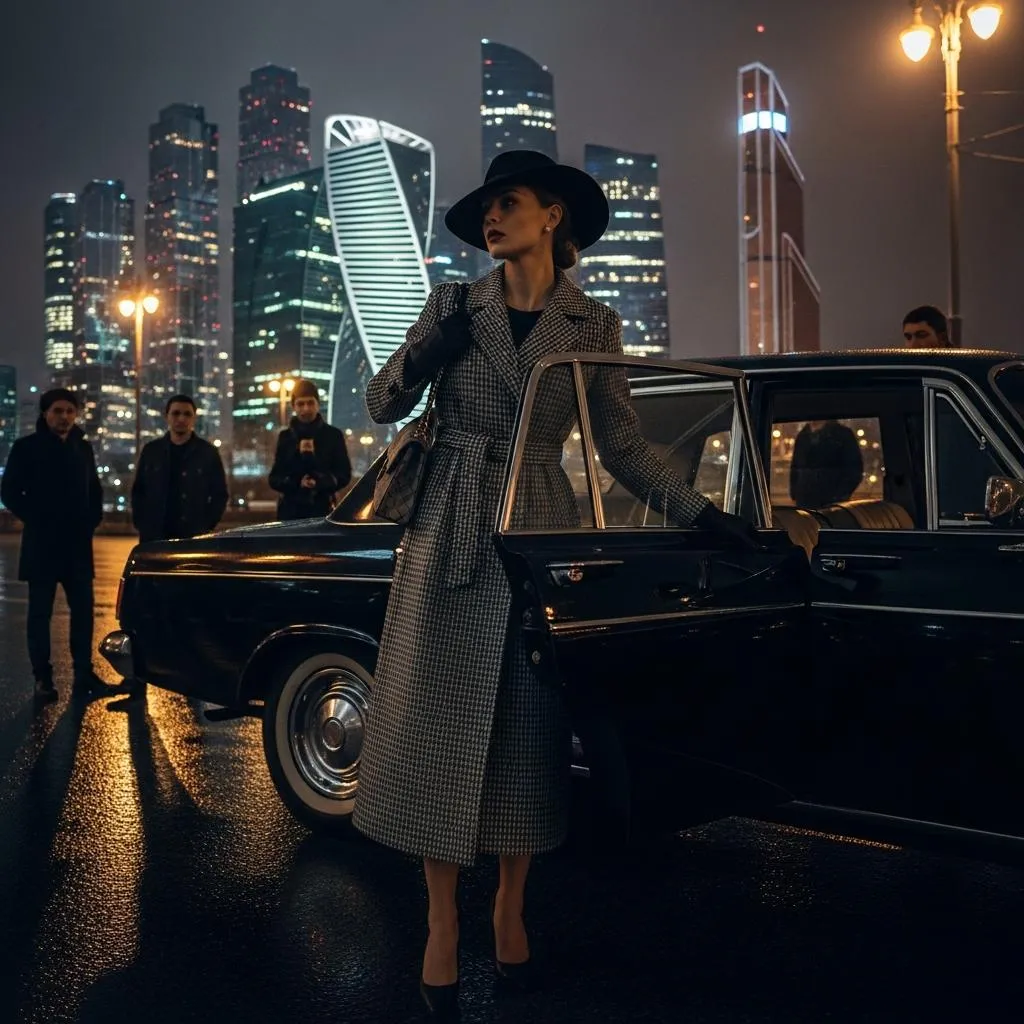
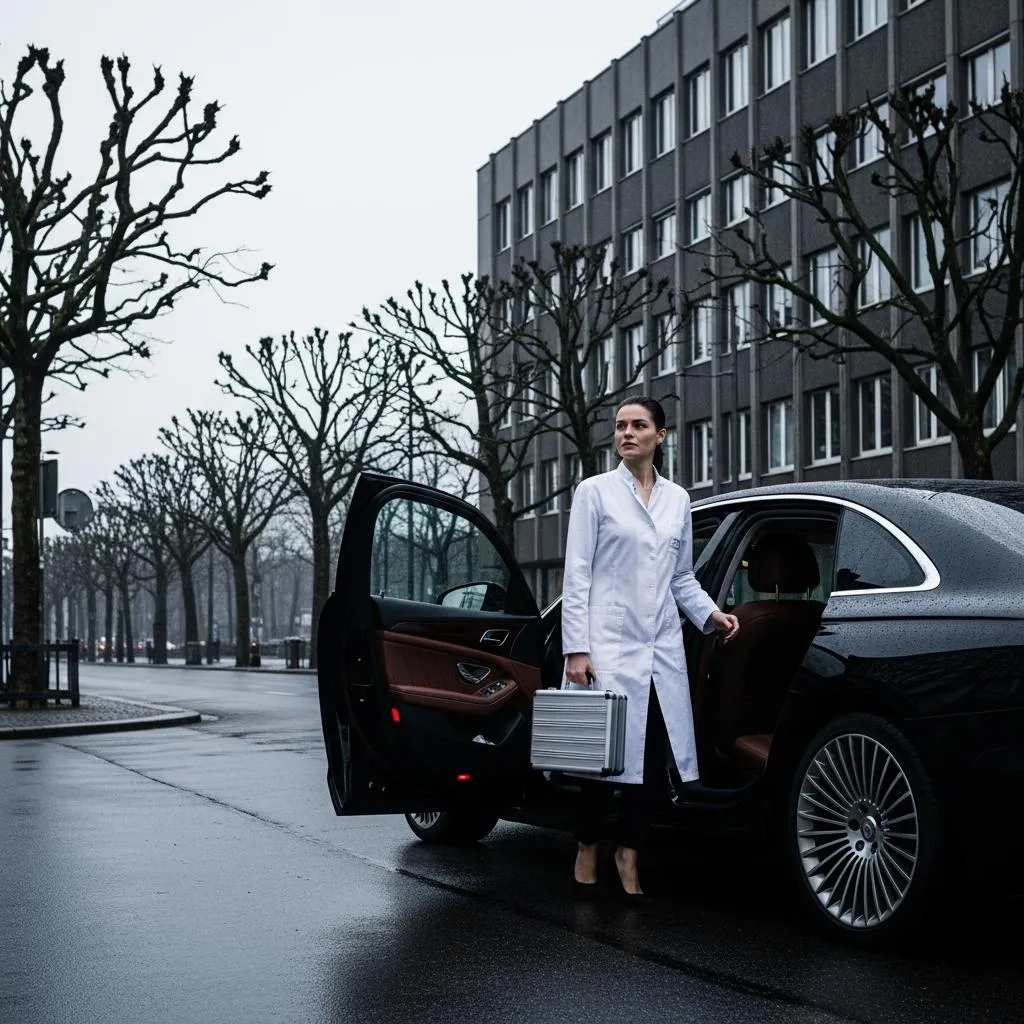
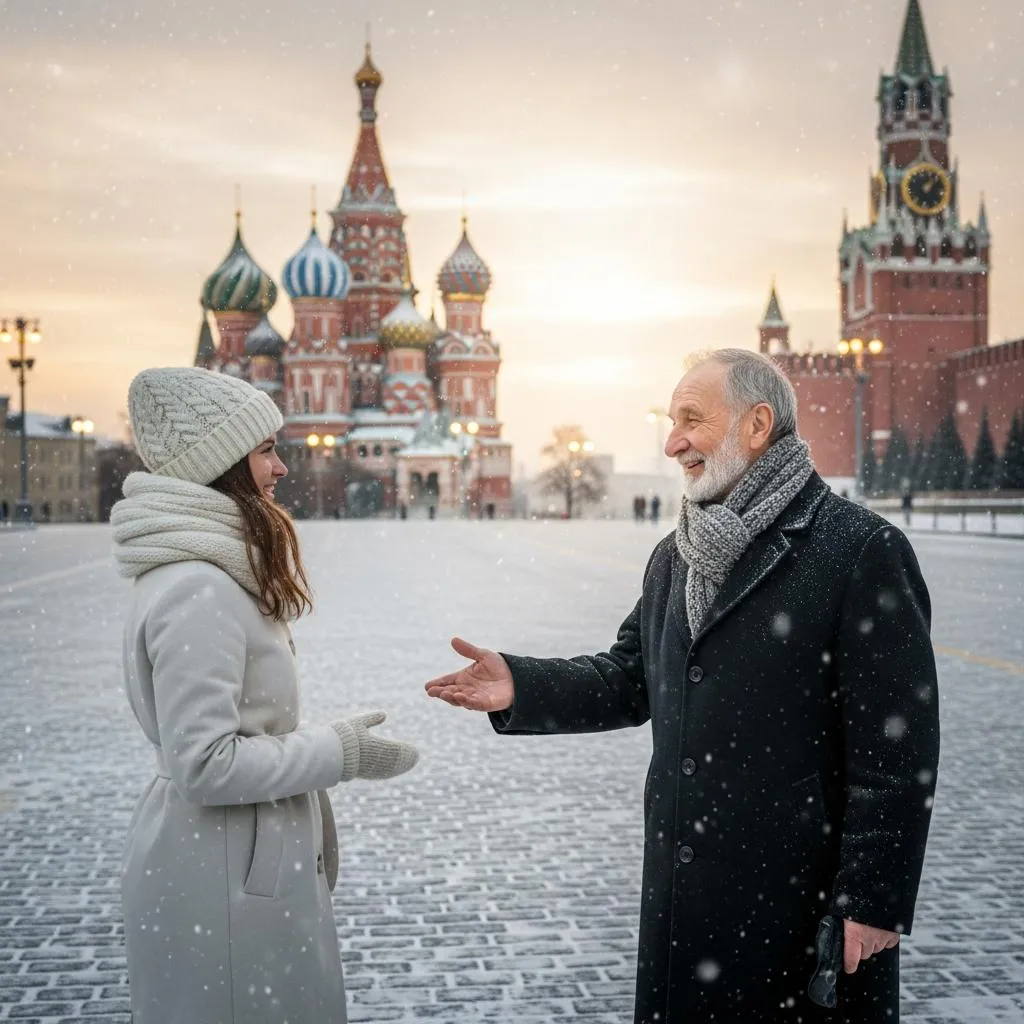

In [74]:
scene_view.select(
    scene_view.trailer_image,
    scene_view.trailer_image.localpath
).collect()

## Wrap-Up

**Across this three-part workshop, you built a complete multimodal AI pipeline:**

- **Act 1**: Visual search - Extract frames, create embeddings, search by image or text
- **Act 2**: Audio search - Detect scenes, transcribe audio, search by semantic meaning
- **Act 3**: Content generation - Chain AI models to create new images and videos

In Act 3, you built a content generation pipeline that chains AI models together using computed columns:

```
┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  INPUT                EXTRACT              ANALYZE                GENERATE                                  │
│                                                                                                             │
│  ┌──────────────┐   ┌────────────────┐   ┌──────────────────┐   ┌──────────────────────────────────────┐  │
│  │   Scenes     │──▶│     Frame      │──▶│  Multimodal AI   │──▶│          Generation                  │  │
│  │              │   │   Extraction   │   │                  │   │                                      │  │
│  │ Video scenes │   │                │   │ Input:           │   │  ┌────────────┐   ┌──────────────┐  │  │
│  │ with         │   │ Input:         │   │ • image (frame)  │   │  │   Imagen   │──▶│     Veo      │  │  │
│  │ metadata:    │   │ • video        │   │ • text (title)   │   │  │    4.0     │   │     3.1      │  │  │
│  │ • video      │   │                │   │ • text (promo)   │   │  │            │   │              │  │  │
│  │ • title      │   │ Output:        │   │ • text (script)  │   │  │ Input:     │   │ Input:       │  │  │
│  │ • promo      │   │ • image        │   │                  │   │  │ • text     │   │ • image      │  │  │
│  │ • transcript │   │                │   │ Model:           │   │  │   (prompt) │   │ • text       │  │  │
│  │              │   │                │   │ Gemini 2.0 Flash │   │  │            │   │   (prompt)   │  │  │
│  │              │   │                │   │                  │   │  │ Output:    │   │              │  │  │
│  │              │   │                │   │ Output:          │   │  │ • image    │   │ Output:      │  │  │
│  │              │   │                │   │ • text (prompt)  │   │  └────────────┘   │ • video      │  │  │
│  │              │   │                │   │                  │   │                   └──────────────┘  │  │
│  └──────────────┘   └────────────────┘   └──────────────────┘   └──────────────────────────────────────┘  │
└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘
```

**What you built:**

You added content generation to your video pipeline. Act 1 gave you visual similarity search (find frames by what they look like). Act 2 gave you semantic audio search (find scenes by what's being said). Act 3 gives you generative AI (create new promotional content from any scene).

Together, these three capabilities form a complete multimodal system. The embeddings from Act 1 power visual search. The scene detection and transcription from Act 2 structure the video data and make it searchable by audio. Act 3 chains multiple AI models—Gemini analyzes frames and transcripts to write prompts, Imagen generates images from those prompts, and Veo can animate them into video clips.

**Each step is declarative:**
- **Input**: Scene data from `scene_view` (built in Act 2)
- **Extract**: Frame extraction via computed column processes all scenes
- **Generate**: AI models chain together via computed columns—Gemini's output becomes Imagen's input
- **Cascade**: When you add new videos to `primetime_vids`, the scene detection, transcription, and generation pipeline processes them

The workflow applies to all data. If you load another video tomorrow, the same pipeline that processed your first video will process the new one.